#说明：purity<0.25的样本不纳入clonality计算

In [1]:
setwd("D:/2.crc_trio/results/")
suppdir="D:/2.crc_trio/results/plot/0.supp/"
maindir="D:/2.crc_trio/results/plot/fig"

library(openxlsx)
library(dplyr)
library(reshape2)

library(ggrepel)
library(ggplot2)
library(ggpubr)
library(ggrepel)
library(ggsci)
library(cowplot)
library(ggpmisc)
library(ggsignif)

library(ComplexHeatmap)
library(maftools)

library(dndscv)
library(VariantAnnotation)

library(breakclone)

source("D:/2.crc_trio/src/cnv-heatmap-master/src/CNVPlottingFunctions.R")

Warning message:
"程辑包'openxlsx'是用R版本4.1.3 来建造的"
Warning message:
"程辑包'dplyr'是用R版本4.1.3 来建造的"

载入程辑包：'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"程辑包'ggrepel'是用R版本4.1.3 来建造的"
载入需要的程辑包：ggplot2

Warning message:
"程辑包'ggplot2'是用R版本4.1.3 来建造的"
Warning message:
"程辑包'ggpubr'是用R版本4.1.3 来建造的"

载入程辑包：'cowplot'


The following object is masked from 'package:ggpubr':

    get_legend


载入需要的程辑包：ggpp

Registered S3 methods overwritten by 'ggpp':
  method                  from   
  heightDetails.titleGrob ggplot2
  widthDetails.titleGrob  ggplot2


载入程辑包：'ggpp'


The following object is masked from 'package:ggplot2':

    annotate


Registered S3 method overwritten by 'ggpmisc':
  method                  from   
  as.character.polynomial polynom

Warning message:
"程辑包'ggsignif'是用R版本4.1.3 来建造的"
载入需要的程辑包：grid

ComplexHeatmap version 2.8.0
Bioconductor

In [3]:
ls()

[1] "maindir"                "makeHeatmapAnnotations" "plotCNVHeatmap"        
[4] "populateCNVMatrix"      "readMeta"               "readSeg"               
[7] "readSeg2"               "suppdir"

# 1.relatedness (old)

In [3]:
load(file="D:/2.crc_trio/draft/toZL/fig4_related/fig4_related.RData")

In [4]:
load(file="D:/2.crc_trio/draft/toZL/fig4_related/Gut2020.RData")

In [5]:
maf=lapply(ls_escc_af, function(x){x$VAF_adj=x$CCF_adj/2; x[which(x$Clonality!="Unknown" & x$Variant_Type=="SNP"),c("Chromosome","Start_Position","Tumor_Sample_Barcode","VAF_adj","CCF_adj","Variant_Type","Clonality")]})
MutTable <- data.table::rbindlist(maf)[,1:4]
colnames(MutTable)=c("Chr", "Pos", "SampleID", "AF")
MutTable=MutTable[which(MutTable$SampleID %in% dat$Sample),] %>% filter(grepl("P$|T$",SampleID))

MutTable<-rbind(MutTable, 
                Gut2020_CRC %>% filter(nchar(Ref)==1 & nchar(Alt)==1 ) %>% 
                dplyr::select(Chr,Start,SampleID,VAF) %>% mutate(Chr=gsub("chr","",Chr)) %>%
                dplyr::rename("Pos"="Start","AF"="VAF") 
               ) %>% filter(AF>0.04) %>% mutate(SampleID=gsub("\\.C\\.","",SampleID))

In [6]:
MutTable %>% mutate(#SampleID=gsub(".","",SampleID),
       SampleID=paste0(substr(SampleID,1,4),"_",substr(SampleID,5,nchar(SampleID)))
                   ) %>% inferPairs(., sep = "_") %>% arrange(Sample1) %>% tail()

,Sample1,Sample2
,<chr>,<chr>
108,CRC1_R1,CRC1_R2
109,CRC1_R1,CRC1_R3
110,CRC1_R2,CRC1_R3
111,CRC2_R1,CRC2_R2
112,CRC2_R1,CRC2_R3
113,CRC2_R2,CRC2_R3


In [7]:
pairs=rbind(data.frame(Sample1=paste0(unique(dat$Patient),"P"), Sample2=paste0(unique(dat$Patient),"T")),
            combn(Gut2020_meta %>% mutate(SampleID=gsub("\\.C\\.","",SampleID)) %>% filter(grepl('CRC1',PatientID) & Barcode=="C") %>% 
                  dplyr::select(SampleID) %>% t() %>% as.vector(),2) %>% 
            t() %>% as.data.frame() %>% dplyr::rename("Sample1"="V1","Sample2"="V2"),
            combn(Gut2020_meta %>% mutate(SampleID=gsub("\\.C\\.","",SampleID)) %>% filter(grepl('CRC2',PatientID) & Barcode=="C") %>% 
                  dplyr::select(SampleID) %>% t() %>% as.vector(),2) %>% 
            t() %>% as.data.frame() %>% dplyr::rename("Sample1"="V1","Sample2"="V2")            
           ) 

In [8]:
pairs %>% dim()

[1] 113   2

In [11]:
reference <- makeReferenceMutations(MutTable, pairs[1:107,])

Making reference based on 11342 possible pairs, this might take a while



In [12]:
rls <- calculateRelatednessMutations(mutationTable = MutTable, pairs = pairs,reference = reference)

In [13]:
rls$patient=substr(rls$Sample1,1,4)
rls$Relatedness=ifelse(rls$pair_scores>0.1,"Related","Unrelated")

In [17]:
rls %>% tail()
rls %>% dim()

,Sample1,Sample2,pair_scores,pair_ps,patient,Relatedness
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
108,CRC1R1,CRC1R2,0.6648538,0,CRC1,Related
109,CRC1R1,CRC1R3,0.8296651,0,CRC1,Related
110,CRC1R2,CRC1R3,0.6825378,0,CRC1,Related
111,CRC2R1,CRC2R2,0.6358492,0,CRC2,Related
112,CRC2R1,CRC2R3,0.4654816,0,CRC2,Related
113,CRC2R2,CRC2R3,0.3588879,0,CRC2,Related


[1] 113   6

In [28]:
save(reference,rls,file="D:/2.crc_trio/draft/toZL/fig4_related/PT_relatedness.RData")

# 2.dnds: filter pi<0.25

In [2]:
load(file="D:/2.crc_trio/draft/toZL/fig4_related/fig4_related.RData")

In [3]:
ls()

[1] "bamdst"                 "cutoff"                 "dat"                   
 [4] "ls_escc_af"             "maf_driver_snv_all"     "maindir"               
 [7] "makeHeatmapAnnotations" "plotCNVHeatmap"         "pm_ci"                 
[10] "pm_dndsout"             "pm_site_out"            "populateCNVMatrix"     
[13] "pp_ci"                  "pp_dndsout"             "pp_site_out"           
[16] "readMeta"               "readSeg"                "readSeg2"              
[19] "suppdir"                "tm_ci"                  "tm_dndsout"            
[22] "tm_site_out"            "Top50_driver"           "Top50_genedat"         
[25] "Top50_geneMatrix"       "tp_ci"                  "tp_dndsout"            
[28] "tp_site_out"            "tt"

In [10]:
## 1.2 dnds estimation

In [4]:
data(list = sprintf("covariates_%s", "hg19_hg38_epigenome_pcawg"), package = "dndscv")
path_refdb = system.file("data", "RefCDS_human_GRCh38.p12_dNdScv.0.1.0.rda", package = "dndscv", mustWork = TRUE)
path_refdb
load(path_refdb)

data(list = sprintf("RefCDS_human_%s", "GRCh38.p12_dNdScv.0.1.0"), package = "dndscv")
gene_list = intersect(sapply(RefCDS, function(x) x$gene_name),row.names(covs))  #为了保持refdp的基因要在covs中，不然会报错

[1] "C:/software/R/R-4.1.0/library/dndscv/data/RefCDS_human_GRCh38.p12_dNdScv.0.1.0.rda"

In [5]:
maf=lapply(ls_escc_af, function(x){x$VAF_adj=x$CCF_adj/2; x[which(x$Clonality!="Unknown"),c("Tumor_Sample_Barcode","Chromosome","Start_Position","Reference_Allele","Tumor_Seq_Allele2","Hugo_Symbol","Variant_Classification")]})
MutTable <- data.table::rbindlist(maf)
colnames(MutTable)[1:5]=c("sampleID","chr", "pos", "ref", "mut")
MutTable$chr=paste0("chr",MutTable$chr)
MutTable=MutTable %>% filter(grepl("P$|T$",sampleID))

In [6]:
MutTable %>% head()

sampleID,chr,pos,ref,mut,Hugo_Symbol,Variant_Classification
<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>
B001P,chr1,1294511,C,T,ACAP3,Missense_Mutation
B001P,chr1,15931632,C,A,SPEN,Missense_Mutation
B001P,chr1,22512926,-,T,ZBTB40,Frame_Shift_Ins
B001P,chr1,74573442,G,A,ERICH3,Silent
B001P,chr1,92075147,C,T,SETSIP,Missense_Mutation
B001P,chr1,101239607,C,T,S1PR1,Missense_Mutation


In [7]:
sgWGS.maf <- maftools::read.maf(maf ="D:/2.crc_trio/scCrypts/result/runtime/VariantFilter/maf_all_B139_vd7_vr4")
sgWGS.df <- rbind(sgWGS.maf@maf.silent,sgWGS.maf@data) 

-Reading
-Validating
--Non MAF specific values in Variant_Classification column:
  Unknown
--Non MAF specific values in Variant_Type column:
  MNP
-Silent variants: 177246 
-Summarizing
-Processing clinical data
--Missing clinical data
-Finished in 3.280s elapsed (1.020s cpu) 


In [8]:
table(MutTable$Variant_Classification)


               3'Flank                  3'UTR                5'Flank 
                   167                   1832                    454 
                 5'UTR        Frame_Shift_Del        Frame_Shift_Ins 
                  1370                   1408                    558 
                   IGR           In_Frame_Del           In_Frame_Ins 
                  1135                    265                     44 
                Intron      Missense_Mutation      Nonsense_Mutation 
                 26293                  21620                   1633 
      Nonstop_Mutation                    RNA                 Silent 
                    26                   2530                   9237 
           Splice_Site Translation_Start_Site                Unknown 
                   428                     41                    404 

In [9]:
#bedtools intersect -a maf_all_B139_vd7_vr4 -b /data/reference/WES/S07604514_Padded.bed -wa >  maf_all_B139_vd7_vr4.wes
sgWGS.wes <- read.table("D:/2.crc_trio/scCrypts/result/runtime/VariantFilter/maf_all_B139_vd7_vr4.wes",sep = '\t', header = F)
colnames(sgWGS.wes) <- colnames(sgWGS.df)
sgWGS.wes <- sgWGS.wes[!duplicated(sgWGS.wes),]

In [10]:
table(sgWGS.df$Tumor_Sample_Barcode)


  B139N_R1_G4   B139N_R2_G1   B139N_R3_G4  B139P1_R1_G2  B139P1_R2_G7 
         2751          1957          3271          2598          5731 
 B139P1_R3_G6  B139P1_R3_G9  B139P1_R4_G3  B139P1_R4_G8 B139P1_R5_G10 
         4142          6589          6737          7773          8122 
 B139P1_R5_G7  B139P1_R6_G1  B139P1_R6_G2  B139P2_R1_G6  B139P2_R2_G2 
         7922          5321          1960          3571          3816 
 B139P2_R2_G7  B139P2_R3_G3  B139P2_R4_G1  B139P2_R4_G5  B139P2_R5_G1 
         3184          2795          4450          3566          3360 
 B139P2_R5_G8  B139P2_R6_G8  B139P3_R2_G6  B139P3_R3_G7  B139P3_R4_G5 
         1703          4122          3905          2913          5551 
 B139P3_R4_G8  B139P3_R5_G1  B139P3_R5_G6  B139P3_R6_G1  B139P3_R6_G8 
         7306          7021          4563          5582          8188 
 B139P4_R1_G6  B139P4_R3_G3  B139P4_R4_G3  B139P4_R5_G6  B139P4_R6_G9 
         2469          5884          4600          3575          4210 
 B139

In [11]:
table(sgWGS.wes$Tumor_Sample_Barcode)


  B139N_R1_G4   B139N_R2_G1   B139N_R3_G4  B139P1_R1_G2  B139P1_R2_G7 
           24            27            19             8           103 
 B139P1_R3_G6  B139P1_R3_G9  B139P1_R4_G3  B139P1_R4_G8 B139P1_R5_G10 
           50            63            64           106            91 
 B139P1_R5_G7  B139P1_R6_G1  B139P1_R6_G2  B139P2_R1_G6  B139P2_R2_G2 
          150            84            24            48            81 
 B139P2_R2_G7  B139P2_R3_G3  B139P2_R4_G1  B139P2_R4_G5  B139P2_R5_G1 
           46            45            57            30            14 
 B139P2_R5_G8  B139P2_R6_G8  B139P3_R2_G6  B139P3_R3_G7  B139P3_R4_G5 
            9            61            90            51            69 
 B139P3_R4_G8  B139P3_R5_G1  B139P3_R5_G6  B139P3_R6_G1  B139P3_R6_G8 
           77           119            52            76           110 
 B139P4_R1_G6  B139P4_R3_G3  B139P4_R4_G3  B139P4_R5_G6  B139P4_R6_G9 
           57            99            36            32            59 
 B139

In [12]:
sgWGS.wes %>% colnames()

[1] "Chromosome"             "Start_Position"         "End_Position"          
 [4] "Reference_Allele"       "Tumor_Seq_Allele2"      "Tumor_Sample_Barcode"  
 [7] "Hugo_Symbol"            "Variant_Classification" "tx"                    
[10] "exon"                   "txChange"               "aaChange"              
[13] "Variant_Type"           "sample_id"              "N_DP"                  
[16] "N_VAF"                  "Total_allele_depth"     "Ref_allele_depth"      
[19] "Alt_allele_depth"       "VAF"                    "Func.refGene"          
[22] "Gene.refGene"           "GeneDetail.refGene"     "ExonicFunc.refGene"    
[25] "AAChange.refGene"       "avsnp150"               "X1000g2015aug_all"     
[28] "cosmic70"               "ExAC_ALL"               "ExAC_AFR"              
[31] "ExAC_AMR"               "ExAC_EAS"               "ExAC_FIN"              
[34] "ExAC_NFE"               "ExAC_OTH"               "ExAC_SAS"              
[37] "esp6500siv2_all"

In [13]:
sgWGS.wes.pp <- sgWGS.wes %>% filter(grepl('B139P1|B139P2|B139P4',Tumor_Sample_Barcode)) %>%  
dplyr::select(Tumor_Sample_Barcode,Chromosome,Start_Position,Reference_Allele,                                                           
       Tumor_Seq_Allele2,Hugo_Symbol,Variant_Classification)
colnames(sgWGS.wes.pp)<-colnames(MutTable)

sgWGS.wes.mp <- sgWGS.wes %>% filter(grepl('B139P3|B139P6',Tumor_Sample_Barcode)) %>%  
dplyr::select(Tumor_Sample_Barcode,Chromosome,Start_Position,Reference_Allele,                                                           
       Tumor_Seq_Allele2,Hugo_Symbol,Variant_Classification)
colnames(sgWGS.wes.mp)<-colnames(MutTable)

In [14]:
sgWGS.wes.pp %>% head()
MutTable %>% head()

,sampleID,chr,pos,ref,mut,Hugo_Symbol,Variant_Classification
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>
1,B139P1_R1_G2,chr8,232794,G,T,ZNF596,Intron
2,B139P1_R1_G2,chr8,47782619,T,C,PRKDC,Intron
3,B139P1_R1_G2,chr8,132036438,G,A,OC90,Intron
4,B139P1_R1_G2,chr8,138367265,C,T,FAM135B,Intron
5,B139P1_R1_G2,chr9,95972935,C,A,ERCC6L2,Missense_Mutation
6,B139P1_R1_G2,chr9,101561885,T,C,RNF20,Intron


sampleID,chr,pos,ref,mut,Hugo_Symbol,Variant_Classification
<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>
B001P,chr1,1294511,C,T,ACAP3,Missense_Mutation
B001P,chr1,15931632,C,A,SPEN,Missense_Mutation
B001P,chr1,22512926,-,T,ZBTB40,Frame_Shift_Ins
B001P,chr1,74573442,G,A,ERICH3,Silent
B001P,chr1,92075147,C,T,SETSIP,Missense_Mutation
B001P,chr1,101239607,C,T,S1PR1,Missense_Mutation


In [261]:
dat %>% filter(grepl('P$|T$',Sample)) %>% filter(derived=="P_Polyclonal" & purity>=0.25 ) %>% dplyr::select(Sample) %>% t() %>% as.vector()

[1] "B001P" "B003P" "B006P" "B010P" "B015P" "B016P" "B018P" "B021P" "B023P"
[10] "B028P" "B031P" "B035P" "B038P" "B046P" "B050P" "B051P" "B054P" "B056P"
[19] "B057P" "B059P" "B060P" "B062P" "B063P" "B065P" "B069P" "B076P" "B081P"
[28] "B102P" "B116P" "B126P"

In [15]:
pp_sg_dndsout<-dndscv(
            rbind(sgWGS.wes.pp[,1:5],
                  MutTable[which(MutTable$sampleID %in% dat$Sample[which(dat$derived=="P_Polyclonal" & dat$purity>=0.25 )]),1:5]),
                gene_list = gene_list,    
                refdb = path_refdb, 
                outmats = T,
                max_coding_muts_per_sample = 5000,
                cv = "hg19_hg38_epigenome_pcawg") 

pm_sg_dndsout<-dndscv(
    rbind(sgWGS.wes.mp[,1:5],
          MutTable[which(MutTable$sampleID %in% dat$Sample[which(dat$derived=="P_Monoclonal" & dat$purity>=0.25 )]),1:5]),
                gene_list = gene_list,    
                refdb = path_refdb, 
                outmats = T,
                max_coding_muts_per_sample = 5000,
                cv = "hg19_hg38_epigenome_pcawg") 

tm_dndsout<-dndscv(MutTable[which(MutTable$sampleID %in% dat$Sample[which(dat$derived=="T_Monoclonal" & dat$purity>=0.25 )]),1:5],
                gene_list = gene_list,    
                refdb = path_refdb, 
                outmats = T,
                max_coding_muts_per_sample = 5000,
                cv = "hg19_hg38_epigenome_pcawg") 


[1] Loading the environment...

[2] Annotating the mutations...

Warning message in dndscv(rbind(sgWGS.wes.pp[, 1:5], MutTable[which(MutTable$sampleID %in% :
"Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results."
Warning message in dndscv(rbind(sgWGS.wes.pp[, 1:5], MutTable[which(MutTable$sampleID %in% :
"Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise."
    Note: 5 mutations removed for exceeding the limit of mutations per gene per sample (see the max_muts_per_gene_per_sample argument in dndscv)

[3] Estimating global rates...

[4] Running dNdSloc...

[5] Running dNdScv...

    Regression model for substitutions (theta = 2.37).

    Regression model for indels (theta = 1.37)

[1] Loading the environment...

[2] Annotating the mutations...

Warning message in dndscv(rbind(sgWGS.wes.mp[, 1:5], MutTable[which(MutTable$sampleI

In [35]:

pp_dndsout<-dndscv(MutTable[which(MutTable$sampleID %in% dat$Sample[which(dat$derived=="P_Polyclonal" & dat$purity>=0.25 )]),1:5],
                gene_list = gene_list,    
                refdb = path_refdb, 
                outmats = T,
                max_coding_muts_per_sample = 5000,
                cv = "hg19_hg38_epigenome_pcawg") 

pm_dndsout<-dndscv(MutTable[which(MutTable$sampleID %in% dat$Sample[which(dat$derived=="P_Monoclonal" & dat$purity>=0.25 )]),1:5],
                gene_list = gene_list,    
                refdb = path_refdb, 
                outmats = T,
                max_coding_muts_per_sample = 5000,
                cv = "hg19_hg38_epigenome_pcawg") 

[1] Loading the environment...

[2] Annotating the mutations...

Warning message in dndscv(MutTable[which(MutTable$sampleID %in% dat$Sample[which(dat$derived == :
"Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results."
Warning message in dndscv(MutTable[which(MutTable$sampleID %in% dat$Sample[which(dat$derived == :
"Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise."
    Note: 5 mutations removed for exceeding the limit of mutations per gene per sample (see the max_muts_per_gene_per_sample argument in dndscv)

[3] Estimating global rates...

[4] Running dNdSloc...

[5] Running dNdScv...

    Regression model for substitutions (theta = 7.62).

    Regression model for indels (theta = 1.24)

[1] Loading the environment...

[2] Annotating the mutations...

Warning message in dndscv(MutTable[which(MutTable$sampleID %in% dat$Sample

In [16]:
ls()

[1] "bamdst"                 "covs"                   "cutoff"                
 [4] "dat"                    "gene_list"              "gr_genes"              
 [7] "known_cancergenes"      "ls_escc_af"             "maf"                   
[10] "maf_driver_snv_all"     "maindir"                "makeHeatmapAnnotations"
[13] "MutTable"               "path_refdb"             "plotCNVHeatmap"        
[16] "pm_ci"                  "pm_dndsout"             "pm_sg_dndsout"         
[19] "pm_site_out"            "populateCNVMatrix"      "pp_ci"                 
[22] "pp_dndsout"             "pp_sg_dndsout"          "pp_site_out"           
[25] "readMeta"               "readSeg"                "readSeg2"              
[28] "RefCDS"                 "sgWGS.df"               "sgWGS.maf"             
[31] "sgWGS.wes"              "sgWGS.wes.mp"           "sgWGS.wes.pp"          
[34] "substmodel"             "suppdir"                "tm_ci"                 
[37] "tm_dndsout"             "tm_site_out"            "Top50_driver"          
[40] "Top50_genedat"          "Top50_geneMatrix"       "tp_ci"                 
[43] "tp_dndsout"             "tp_site_out"            "tt"

In [28]:
##dnds for three groups

pp_dndsout<-dndscv(MutTable[which(MutTable$sampleID %in% dat$Sample[which(dat$derived=="P_Polyclonal" & dat$purity>=0.25 )]),1:5],
                gene_list = gene_list,    
                refdb = path_refdb, 
                outmats = T,
                max_coding_muts_per_sample = 5000,
                cv = "hg19_hg38_epigenome_pcawg") 

pm_dndsout<-dndscv(MutTable[which(MutTable$sampleID %in% dat$Sample[which(dat$derived=="P_Monoclonal" & dat$purity>=0.25 )]),1:5],
                gene_list = gene_list,    
                refdb = path_refdb, 
                outmats = T,
                max_coding_muts_per_sample = 5000,
                cv = "hg19_hg38_epigenome_pcawg") 

tp_dndsout<-dndscv(MutTable[which(MutTable$sampleID %in% dat$Sample[which(dat$derived=="T_Polyclonal" & dat$purity>=0.25 )]),1:5],
                gene_list = gene_list,    
                refdb = path_refdb, 
                outmats = T,
                max_coding_muts_per_sample = 5000,
                cv = "hg19_hg38_epigenome_pcawg") 

tm_dndsout<-dndscv(MutTable[which(MutTable$sampleID %in% dat$Sample[which(dat$derived=="T_Monoclonal" & dat$purity>=0.25 )]),1:5],
                gene_list = gene_list,    
                refdb = path_refdb, 
                outmats = T,
                max_coding_muts_per_sample = 5000,
                cv = "hg19_hg38_epigenome_pcawg") 

pp_site_out=sitednds(dndsout=pp_dndsout)
pm_site_out=sitednds(dndsout=pm_dndsout)
tp_site_out=sitednds(dndsout=tp_dndsout)
tm_site_out=sitednds(dndsout=tm_dndsout)

pp_ci=geneci(dndsout=pp_dndsout)
pm_ci=geneci(dndsout=pm_dndsout)
tp_ci=geneci(dndsout=tp_dndsout)
tm_ci=geneci(dndsout=tm_dndsout)

#save(p_dndsout,t_dndsout,p_site_out,t_site_out,p_ci,t_ci,file="runtime/output/step5_dndsout.RData")
#save(p_dndsout,mp_dndsout,pp_dndsout,t_dndsout,p_site_out,pp_site_out,mp_site_out,t_site_out,p_ci,pp_ci,mp_ci,t_ci,file="runtime/output/step5_dndsout.RData")

[1] Loading the environment...

[2] Annotating the mutations...

Warning message in dndscv(MutTable[which(MutTable$sampleID %in% dat$Sample[which(dat$derived == :
"Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results."
Warning message in dndscv(MutTable[which(MutTable$sampleID %in% dat$Sample[which(dat$derived == :
"Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise."
    Note: 5 mutations removed for exceeding the limit of mutations per gene per sample (see the max_muts_per_gene_per_sample argument in dndscv)

[3] Estimating global rates...

[4] Running dNdSloc...

[5] Running dNdScv...

    Regression model for substitutions (theta = 7.62).

    Regression model for indels (theta = 1.24)

[1] Loading the environment...

[2] Annotating the mutations...

Warning message in dndscv(MutTable[which(MutTable$sampleID %in% dat$Sample

[1] 0.052
[1] 0.1
[1] 0.16
[1] 0.21
[1] 0.26
[1] 0.31
[1] 0.36
[1] 0.42
[1] 0.47
[1] 0.52
[1] 0.57
[1] 0.62
[1] 0.68
[1] 0.73
[1] 0.78
[1] 0.83
[1] 0.88
[1] 0.94
[1] 0.99


Calculating CI95 across all genes...



[1] 0.052
[1] 0.1
[1] 0.16
[1] 0.21
[1] 0.26
[1] 0.31
[1] 0.36
[1] 0.42
[1] 0.47
[1] 0.52
[1] 0.57
[1] 0.62
[1] 0.68
[1] 0.73
[1] 0.78
[1] 0.83
[1] 0.88
[1] 0.94
[1] 0.99


Calculating CI95 across all genes...



[1] 0.052
[1] 0.1
[1] 0.16
[1] 0.21
[1] 0.26
[1] 0.31
[1] 0.36
[1] 0.42
[1] 0.47
[1] 0.52
[1] 0.57
[1] 0.62
[1] 0.68
[1] 0.73
[1] 0.78
[1] 0.83
[1] 0.88
[1] 0.94
[1] 0.99


Calculating CI95 across all genes...



[1] 0.052
[1] 0.1
[1] 0.16
[1] 0.21
[1] 0.26
[1] 0.31
[1] 0.36
[1] 0.42
[1] 0.47
[1] 0.52
[1] 0.57
[1] 0.62
[1] 0.68
[1] 0.73
[1] 0.78
[1] 0.83
[1] 0.88
[1] 0.94
[1] 0.99


In [32]:
ls()

[1] "bamdst"                 "covs"                   "cutoff"                
 [4] "dat"                    "gene_list"              "gr_genes"              
 [7] "known_cancergenes"      "ls_escc_af"             "maf"                   
[10] "maf_driver_snv_all"     "maindir"                "makeHeatmapAnnotations"
[13] "MutTable"               "path_refdb"             "plotCNVHeatmap"        
[16] "pm_ci"                  "pm_dndsout"             "pm_site_out"           
[19] "populateCNVMatrix"      "pp_ci"                  "pp_dndsout"            
[22] "pp_site_out"            "readMeta"               "readSeg"               
[25] "readSeg2"               "RefCDS"                 "substmodel"            
[28] "suppdir"                "tm_ci"                  "tm_dndsout"            
[31] "tm_site_out"            "Top50_driver"           "Top50_genedat"         
[34] "Top50_geneMatrix"       "tp_ci"                  "tp_dndsout"            
[37] "tp_site_out"            "tt"

In [33]:
save(dat,ls_escc_af,file="D:/2.crc_trio/draft/toZL/fig4_related/Input_v2.RData")

In [31]:
#save(pm_dndsout,pp_dndsout,tp_dndsout,tm_dndsout,
#     pp_site_out,pm_site_out,tp_site_out,tm_site_out,
#     pp_ci,pm_ci,tp_ci,tm_ci,
#     file="D:/2.crc_trio/draft/toZL/fig4_related/DnDs_v2.RData")

# 3.driver_mat

In [4]:
load(file="D:/2.crc_trio/draft/toZL/fig4_related/Input_v2.RData")

In [5]:
ls()

[1] "dat"                    "ls_escc_af"             "maindir"               
 [4] "makeHeatmapAnnotations" "plotCNVHeatmap"         "populateCNVMatrix"     
 [7] "readMeta"               "readSeg"                "readSeg2"              
[10] "suppdir"

In [1]:
#load(file="D:/2.crc_trio/draft/toZL/fig4_related/DnDs_v2.RData")

In [7]:
ls()

[1] "dat"                    "ls_escc_af"             "maindir"               
 [4] "makeHeatmapAnnotations" "plotCNVHeatmap"         "pm_ci"                 
 [7] "pm_dndsout"             "pm_site_out"            "populateCNVMatrix"     
[10] "pp_ci"                  "pp_dndsout"             "pp_site_out"           
[13] "readMeta"               "readSeg"                "readSeg2"              
[16] "suppdir"                "tm_ci"                  "tm_dndsout"            
[19] "tm_site_out"            "tp_ci"                  "tp_dndsout"            
[22] "tp_site_out"

In [263]:
dat$Patient

[1] "B001" "B001" "B001" "B001" "B001" "B001" "B002" "B002" "B002" "B002"
 [11] "B002" "B002" "B003" "B003" "B003" "B003" "B003" "B003" "B004" "B004"
 [21] "B005" "B005" "B006" "B006" "B007" "B007" "B008" "B008" "B009" "B009"
 [31] "B010" "B010" "B012" "B012" "B013" "B013" "B014" "B014" "B015" "B015"
 [41] "B016" "B016" "B017" "B017" "B018" "B018" "B019" "B019" "B020" "B020"
 [51] "B021" "B021" "B022" "B022" "B023" "B023" "B024" "B024" "B025" "B025"
 [61] "B026" "B026" "B027" "B027" "B028" "B028" "B029" "B029" "B030" "B030"
 [71] "B031" "B031" "B033" "B033" "B034" "B034" "B035" "B035" "B036" "B036"
 [81] "B037" "B037" "B038" "B038" "B039" "B039" "B041" "B041" "B042" "B042"
 [91] "B044" "B044" "B045" "B045" "B046" "B046" "B048" "B048" "B049" "B049"
[101] "B050" "B050" "B051" "B051" "B052" "B052" "B053" "B053" "B054" "B054"
[111] "B056" "B056" "B057" "B057" "B058" "B058" "B059" "B059" "B060" "B060"
[121] "B061" "B061" "B062" "B062" "B063" "B063" "B064" "B064" "B065" "B065"
[131] "B066" "B066" "B067" "B067" "B068" "B068" "B069" "B069" "B071" "B071"
[141] "B073" "B073" "B074" "B074" "B075" "B075" "B076" "B076" "B077" "B077"
[151] "B079" "B079" "B081" "B081" "B083" "B083" "B084" "B084" "B085" "B085"
[161] "B086" "B086" "B087" "B087" "B088" "B088" "B090" "B090" "B091" "B091"
[171] "B092" "B092" "B093" "B093" "B094" "B094" "B095" "B095" "B096" "B096"
[181] "B097" "B097" "B098" "B098" "B099" "B099" "B100" "B100" "B102" "B102"
[191] "B104" "B104" "B105" "B105" "B106" "B106" "B108" "B108" "B110" "B110"
[201] "B111" "B111" "B112" "B112" "B113" "B113" "B114" "B114" "B116" "B116"
[211] "B118" "B118" "B119" "B119" "B120" "B120" "B122" "B122" "B123" "B123"
[221] "B124" "B124" "B125" "B125" "B126" "B126" "B126" "B126"

In [8]:
load(file="runtime/output/step2_01_maftools.Rdata")

In [9]:
ls()

[1] "colonGene"              "dat"                    "gene_mat"              
 [4] "geneMatrix"             "ls_escc_af"             "maf_driver_snv_all"    
 [7] "maindir"                "makeHeatmapAnnotations" "panGene"               
[10] "plotCNVHeatmap"         "pm_ci"                  "pm_dndsout"            
[13] "pm_site_out"            "populateCNVMatrix"      "pp_ci"                 
[16] "pp_dndsout"             "pp_site_out"            "readMeta"              
[19] "readSeg"                "readSeg2"               "suppdir"               
[22] "tm_ci"                  "tm_dndsout"             "tm_site_out"           
[25] "Top50_driver"           "tp_ci"                  "tp_dndsout"            
[28] "tp_site_out"

In [10]:
dat %>% filter(purity>=0.25) %>% filter(grepl("P$",Sample)) %>% #filter(total_SNP>50) %>%
group_by(Lineage) %>% dplyr::count() %>% mutate(f=n/102) #5个P样本purity<0.25

dat %>% filter(purity>=0.25) %>% filter(grepl("T$",Sample)) %>% #filter(total_SNP>50) %>%
group_by(Lineage) %>% dplyr::count() %>% mutate(f=n/86) #21个T样本purity<0.25

Lineage,n,f
<chr>,<int>,<dbl>
Monoclonal,72,0.7058824
Polyclonal,30,0.2941176


Lineage,n,f
<chr>,<int>,<dbl>
Monoclonal,79,0.91860465
Polyclonal,7,0.08139535


In [31]:
dim(geneMatrix)

[1] 232 678

In [262]:
maf_driver_snv_all %>% head()

Patient_ID,Tumor_Sample_Barcode,derived,Hugo_Symbol,CCF_adj,isColonG
<chr>,<fct>,<chr>,<chr>,<dbl>,<dbl>
B001,B001P,P,SPEN,0.264,0
B001,B001P,P,SPTA1,0.093,1
B001,B001P,P,PTPRC,0.512,1
B001,B001P,P,TP63,0.528,0
B001,B001P,P,APC,0.605,1
B001,B001P,P,MARK2,0.124,0


In [289]:
#sn=dat %>% filter(purity>=0.25) %>% filter(grepl("P$|T$",Sample) & derived!="T_Polyclonal" ) %>% dplyr::select(Sample) %>% t() #选择目标样本：purity>=0.25, 且具有clonality, T_num= 79
sn=dat %>% filter(purity>=0.25) %>% filter(grepl("P$|T$",Sample) ) %>% dplyr::select(Sample) %>% t() #选择目标样本：purity>=0.25, 且具有clonality, T_num=86
freq_pt=maf_driver_snv_all %>%
filter(Tumor_Sample_Barcode %in% sn)  %>% 
#filter(Patient_ID != "B082" & Patient_ID != "B127") %>%
distinct(Patient_ID,Tumor_Sample_Barcode,derived,Hugo_Symbol) %>%
aggregate(Tumor_Sample_Barcode~Hugo_Symbol+derived,.,length) %>% 
mutate(frac=ifelse(grepl("P$",derived),
                   round(Tumor_Sample_Barcode/102*100,1),
                   round(Tumor_Sample_Barcode/86*100,1) ))%>% filter(frac >= 8.5) 
cutoff=freq_pt %>%
dplyr::select(columns="Hugo_Symbol") %>% t() %>% as.vector() %>%intersect(Top50_driver,.) 

print("showing freq of genes in polyps or crcs:")
freq_pt %>% acast(.,Hugo_Symbol~derived,value.var = 'frac') %>% t()

print("genes with freq>8.5% in polyps or crcs: ")
cutoff

cutoff=

[1] "showing freq of genes in polyps or crcs:"


,APC,ARID1A,BCL9L,CTNNB1,FAT3,FAT4,FBXW7,KRAS,LRP1B,PCDH17,PIK3CA,SMAD4,SMARCA4,SOX9,SPTA1,TCF7L2,TP53,ZFP36L2
P,82.4,9.8,14.7,8.8,NA,11.8,13.7,26.5,NA,NA,NA,NA,10.8,17.6,8.8,19.6,12.7,13.7
T,82.6,NA,NA,NA,12.8,12.8,29.1,38.4,17.4,10.5,16.3,11.6,NA,11.6,NA,9.3,72.1,9.3


[1] "genes with freq>8.5% in polyps or crcs: "


[1] "APC"     "TP53"    "KRAS"    "FBXW7"   "TCF7L2"  "SOX9"    "LRP1B"  
 [8] "FAT4"    "ZFP36L2" "ARID1A"  "FAT3"    "PCDH17"  "SPTA1"   "PIK3CA" 
[15] "BCL9L"   "SMAD4"   "SMARCA4" "CTNNB1"

In [323]:
#drivergene_list(n=346) from Prof.Hu. 
#"where the putative driver genes were curated by merging all TCGA pan-cancer drivers [refs] (n = 299) and additional CRC-specific drivers (n = 47) annotated by the COSMIC Cancer Gene Census (https://cancer.sanger.ac.uk/census)."
#ref: Bailey, et al. Comprehensive Characterization of Cancer Driver Genes and Mutations. 和COSMIC
ex_gene=c('LRP1B','FAT4','PCDH17')

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

[1] "APC"     "TP53"    "KRAS"    "FBXW7"   "TCF7L2"  "SOX9"    "ZFP36L2"
 [8] "ARID1A"  "FAT3"    "SPTA1"   "PIK3CA"  "BCL9L"   "SMAD4"   "SMARCA4"
[15] "CTNNB1"

In [329]:
#后续要进行多重比较，可以先别只关注top50,或者应该所有基因都算一遍，然后再focus到top50上
#Top50_geneMatrix<-t(geneMatrix[dat %>% filter(purity>=0.25) %>% filter(grepl("P$|T$",Sample) & derived!="T_Polyclonal") %>% dplyr::select(Sample) %>% t(),Top50_driver]) 
#后续要进行多重比较，可以先别只关注cutoff基因
Top50_geneMatrix<-t(geneMatrix[dat %>% filter(purity>=0.25) %>% filter(grepl("P$|T$",Sample) & derived!="T_Polyclonal") %>% dplyr::select(Sample) %>% t(), setdiff(cutoff,ex_gene) ]) 
Top50_geneMatrix %>% head(n=2)
print("Number of T_mono:")
grep("T$",colnames(Top50_geneMatrix)) %>% length() 

Top50_genedat=as.data.frame(Top50_geneMatrix) %>% apply(.,1,function(x)x=ifelse(nchar(x)>0,1,0)) %>% reshape2::melt() %>% dplyr::rename(c("Sample"="Var1","Gene"="Var2"))
Top50_genedat = left_join(Top50_genedat,dat %>% dplyr::select(Sample,derived,Lineage),by="Sample")
Top50_genedat %>% head(n=2)

Top50_genestat<-aggregate(value~Gene+derived,Top50_genedat,sum) %>% 
mutate(frac=ifelse(derived=="P_Polyclonal",round(value/30*100,2),
                   ifelse(derived=="P_Monoclonal",round(value/72*100,2), round(value/79*100,2) ) ))
Top50_genestat %>% head(n=2)

print("keys gene ammong three groups:")
Top50_genestat %>% acast(.,Gene~derived,value.var = 'frac') %>% t()  

,B001P,B001T,B002P,B002T,B003P,B004P,B004T,B005P,B006P,B006T,...,B120T,B122P,B122T,B123P,B123T,B124P,B124T,B125P,B126P,B126T
APC,Nonsense_Mutation,Nonsense_Mutation,Nonsense_Mutation,Nonsense_Mutation,Multi_Hit,Frame_Shift_Ins,,,Multi_Hit,Multi_Hit,...,Multi_Hit,Frame_Shift_Del,Multi_Hit,,,Multi_Hit,Nonsense_Mutation,Frame_Shift_Del,Frame_Shift_Del,
TP53,,Missense_Mutation,Splice_Site,,,Splice_Site,Nonsense_Mutation,,,,...,Missense_Mutation,,Missense_Mutation,,Missense_Mutation,,,,,Missense_Mutation


[1] "Number of T_mono:"


[1] 79

,Sample,Gene,value,derived,Lineage
,<chr>,<fct>,<dbl>,<fct>,<chr>
1,B001P,APC,1,P_Polyclonal,Polyclonal
2,B001T,APC,1,T_Monoclonal,Monoclonal


,Gene,derived,value,frac
,<fct>,<fct>,<dbl>,<dbl>
1,APC,P_Polyclonal,23,76.67
2,TP53,P_Polyclonal,1,3.33


[1] "keys gene ammong three groups:"


,APC,TP53,KRAS,FBXW7,TCF7L2,SOX9,ZFP36L2,ARID1A,FAT3,SPTA1,PIK3CA,BCL9L,SMAD4,SMARCA4,CTNNB1
P_Polyclonal,76.67,3.33,6.67,13.33,13.33,3.33,23.33,3.33,6.67,13.33,0.00,13.33,3.33,13.33,10.00
P_Monoclonal,84.72,16.67,34.72,13.89,22.22,23.61,9.72,12.50,4.17,6.94,1.39,15.28,0.00,9.72,8.33
T_Monoclonal,87.34,77.22,40.51,31.65,10.13,11.39,10.13,7.59,13.92,7.59,16.46,3.80,11.39,2.53,1.27


In [330]:
#calculation the different by fisher.test beween any two group. ps. fdr affected by number of genes (+).                 
tt=reshape2::dcast(Top50_genestat[,1:3],Gene~derived)
#P_poly vs P_mono
tt$p12=apply(tt[,c(2,3)],1,function(x){ 
      mat=matrix(c(x['P_Polyclonal'],30-x['P_Polyclonal'],
                             x['P_Monoclonal'],72-x['P_Monoclonal']),
                          ncol=2
                          )
      p1=fisher.test(mat,alternative = "greater" )
      p2=fisher.test(mat,alternative = "less" )
      pvalue=p1$p.value
      if(pvalue > p2$p.value) pvalue=p2$p.value     
      format(pvalue,scientific = T,digits = 3)
 })
tt$q12=format( p.adjust(as.numeric(tt$p12),method='fdr',n=length(tt$p12) ) ,scientific = T,digits = 3)
#P_mono vs T_mono
tt$p23=apply(tt[,c(3,4)],1,function(x){
      mat=matrix(c(x['P_Monoclonal'],72-x['P_Monoclonal'],
                             x['T_Monoclonal'],79-x['T_Monoclonal']),
                          ncol=2
                          )
      p1=fisher.test(mat,alternative = "greater" )
      p2=fisher.test(mat,alternative = "less" )
      pvalue=p1$p.value
      if(pvalue > p2$p.value) pvalue=p2$p.value     
      format(pvalue,scientific = T,digits = 3)
 })

tt$q23=format( p.adjust(as.numeric(tt$p23),method='fdr',n=length(tt$p23) ) ,scientific = T,digits = 3)
##P_poly vs T_mono
tt$p13=apply(tt[,c(2,4)],1,function(x){
      mat=matrix(c(x['P_Polyclonal'],30-x['P_Polyclonal'],
                             x['T_Monoclonal'],79-x['T_Monoclonal']),
                          ncol=2
                          )
      p1=fisher.test(mat,alternative = "greater" )
      p2=fisher.test(mat,alternative = "less" )
      pvalue=p1$p.value
      if(pvalue > p2$p.value) pvalue=p2$p.value     
      format(pvalue,scientific = T,digits = 3)
 })

tt$q13=format(p.adjust(as.numeric(tt$p13),method='fdr',n=length(tt$p13) ) ,scientific = T,digits = 3)

## the difference among three groups using K-W test
tt$p123=apply(tt[,c(2,3,4)],1,function(x){
        mat=data.frame(
            group = c(rep("P_Polyclonal", 30), rep("P_Monoclonal", 72), rep("T_Monoclonal", 79)),
            type = c(rep("Positive", x['P_Polyclonal'] ), rep("Negative", 30-x['P_Polyclonal']), 
                   rep("Positive", x['P_Monoclonal']), rep("Negative", 72-x['P_Monoclonal']), 
                   rep("Positive", x['T_Monoclonal']), rep("Negative", 79-x['T_Monoclonal'] ))
           )

      pvalue=kruskal.test(group~type, mat)$p.value
      format(pvalue,scientific = T,digits = 3)
 })

tt$q123=format(p.adjust(as.numeric(tt$p123),method='fdr',n=length(tt$p123) ) ,scientific = T,digits = 3)


In [331]:
tt %>% arrange(desc(T_Monoclonal))

Gene,P_Polyclonal,P_Monoclonal,T_Monoclonal,p12,q12,p23,q23,p13,q13,p123,q123
<fct>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
APC,23,61,69,2.42e-01,4.67e-01,4.09e-01,4.72e-01,1.41e-01,2.35e-01,6.27e-01,7.23e-01
TP53,1,12,61,5.69e-02,2.62e-01,2.63e-14,3.94e-13,4.7e-13,7.05e-12,1.56e-14,2.34e-13
KRAS,2,25,32,2.11e-03,3.16e-02,2.87e-01,3.59e-01,3.2e-04,2.40e-03,3.89e-01,4.86e-01
FBXW7,4,10,25,6.07e-01,6.50e-01,7.87e-03,2.95e-02,4.14e-02,1.43e-01,7.35e-03,2.76e-02
PIK3CA,0,1,13,7.06e-01,7.06e-01,1.03e-03,7.73e-03,1.13e-02,5.65e-02,4.54e-04,3.40e-03
FAT3,2,3,11,4.61e-01,6.16e-01,3.5e-02,7.12e-02,2.45e-01,3.06e-01,3.42e-02,7.86e-02
SOX9,1,17,9,9.89e-03,7.42e-02,3.8e-02,7.12e-02,1.79e-01,2.44e-01,4.18e-02,7.86e-02
SMAD4,1,0,9,2.94e-01,4.90e-01,2.33e-03,1.17e-02,1.79e-01,2.44e-01,2.15e-03,1.07e-02
TCF7L2,4,16,8,2.28e-01,4.67e-01,3.5e-02,7.12e-02,4.3e-01,4.30e-01,4.19e-02,7.86e-02


In [332]:
##KRAS：P_poly(n=30)  vs P_mono+T_mono (n= 72+79 =151)
fisher.test(matrix(c(2,28,57,94),nrow = 2),alternative = "less")


	Fisher's Exact Test for Count Data

data:  matrix(c(2, 28, 57, 94), nrow = 2)
p-value = 0.0003585
alternative hypothesis: true odds ratio is less than 1
95 percent confidence interval:
 0.0000000 0.4252822
sample estimates:
odds ratio 
 0.1187803 


In [333]:
32/79
25/72

[1] 0.4050633

[1] 0.3472222

In [334]:
##SPAT1：P_poly(n=30)  vs P_mono+T_mono (n= 72+79 =151)
fisher.test(matrix(c(4,26,11,140),nrow = 2),alternative = "greater")


	Fisher's Exact Test for Count Data

data:  matrix(c(4, 26, 11, 140), nrow = 2)
p-value = 0.2215
alternative hypothesis: true odds ratio is greater than 1
95 percent confidence interval:
 0.5356776       Inf
sample estimates:
odds ratio 
  1.949445 


In [293]:
##ZFP36L2：P_poly(n=30)  vs P_mono+T_mono (n= 72+79 =151)
fisher.test(matrix(c(7,23,15,136),nrow = 2),alternative = "greater")


	Fisher's Exact Test for Count Data

data:  matrix(c(7, 23, 15, 136), nrow = 2)
p-value = 0.04717
alternative hypothesis: true odds ratio is greater than 1
95 percent confidence interval:
 1.015818      Inf
sample estimates:
odds ratio 
  2.739923 


In [294]:
#data quality
bamdst<-read.table('./CRC_bamdst.txt',header = F,row.names = 1,sep = '\t') 
bamdst<-as.data.frame(t(bamdst)) %>% dplyr::rename("Sample"="Term")
colnames(bamdst)=gsub(" ","",colnames(bamdst) )

In [295]:
ls()

[1] "aa"                     "bamdst"                 "bb"                    
 [4] "colonGene"              "cutoff"                 "dat"                   
 [7] "freq_pt"                "gene_mat"               "geneMatrix"            
[10] "ls_escc_af"             "maf_driver_snv_all"     "maindir"               
[13] "makeHeatmapAnnotations" "mat"                    "mytheme"               
[16] "p1"                     "p2"                     "panGene"               
[19] "plotCNVHeatmap"         "pm_ci"                  "pm_dndsout"            
[22] "pm_site_out"            "populateCNVMatrix"      "pp_ci"                 
[25] "pp_dndsout"             "pp_site_out"            "readMeta"              
[28] "readSeg"                "readSeg2"               "sn"                    
[31] "suppdir"                "tm_ci"                  "tm_dndsout"            
[34] "tm_site_out"            "Top50_driver"           "Top50_genedat"         
[37] "Top50_geneMatrix"       "Top50_genestat"         "tp_ci"                 
[40] "tp_dndsout"             "tp_site_out"            "tt"

In [296]:
bamdst %>% head()

,Sample,[Total]RawReads(Allreads),[Total]QCFailreads,[Total]RawData(Mb),[Total]PairedReads,[Total]MappedReads,[Total]FractionofMappedReads,[Total]MappedData(Mb),[Total]FractionofMappedData(Mb),[Total]Properlypaired,...,[flank]FractionofflankReadsinallreads,[flank]FractionofflankReadsinmappedreads,[flank]flankData(Mb),[flank]FractionofflankDatainalldata,[flank]FractionofflankDatainmappeddata,[flank]Coverage(>0x),[flank]Coverage(>=4x),[flank]Coverage(>=10x),[flank]Coverage(>=30x),[flank]Coverage(>=100x)
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
V2,B001N.x,227176376,0,34059.94,227017202,226821053,99.84%,34023.16,99.89%,225588332,...,66.02%,66.12%,13069.81,38.37%,38.41%,99.53%,98.41%,95.60%,84.45%,54.26%
V3,B001N.y,140355550,0,21041.64,140242658,140099430,99.82%,21014.91,99.87%,139261214,...,64.12%,64.24%,7795.31,37.05%,37.09%,99.16%,96.67%,90.60%,72.12%,36.27%
V4,B001N,86820826,0,13018.30,86774544,86721623,99.89%,13008.24,99.92%,86327118,...,69.09%,69.17%,5274.50,40.52%,40.55%,98.61%,95.51%,88.23%,64.95%,22.48%
V5,B001P.x,292297648,0,43817.46,292034460,291737998,99.81%,43760.70,99.87%,289409862,...,66.05%,66.18%,16212.16,37.00%,37.05%,99.20%,97.08%,92.32%,79.52%,54.88%
V6,B001P.y,122702033,0,18390.75,122560774,122406624,99.76%,18360.99,99.84%,121220890,...,62.26%,62.41%,6373.54,34.66%,34.71%,97.40%,91.05%,80.44%,60.14%,29.13%
V7,B001P,169595615,0,25426.71,169473686,169331374,99.84%,25399.71,99.89%,168188972,...,68.79%,68.90%,9838.62,38.69%,38.74%,98.43%,94.89%,88.06%,71.40%,41.60%


In [335]:
save(Top50_driver,Top50_genedat,Top50_genestat,Top50_geneMatrix,tt,
     maf_driver_snv_all,cutoff,bamdst,ex_gene,
     file="D:/2.crc_trio/draft/toZL/fig4_related/Drivers_v3.RData")

In [298]:
ls()

[1] "aa"                     "bamdst"                 "bb"                    
 [4] "colonGene"              "cutoff"                 "dat"                   
 [7] "freq_pt"                "gene_mat"               "geneMatrix"            
[10] "ls_escc_af"             "maf_driver_snv_all"     "maindir"               
[13] "makeHeatmapAnnotations" "mat"                    "mytheme"               
[16] "p1"                     "p2"                     "panGene"               
[19] "plotCNVHeatmap"         "pm_ci"                  "pm_dndsout"            
[22] "pm_site_out"            "populateCNVMatrix"      "pp_ci"                 
[25] "pp_dndsout"             "pp_site_out"            "readMeta"              
[28] "readSeg"                "readSeg2"               "sn"                    
[31] "suppdir"                "tm_ci"                  "tm_dndsout"            
[34] "tm_site_out"            "Top50_driver"           "Top50_genedat"         
[37] "Top50_geneMatrix"       "Top50_genestat"         "tp_ci"                 
[40] "tp_dndsout"             "tp_site_out"            "tt"

# 4.Supplemenatry Table

In [4]:
load(file="D:/2.crc_trio/draft/toZL/fig4_related/Input_v2.RData")

In [5]:
load(file="D:/2.crc_trio/draft/toZL/fig4_related/PT_relatedness.RData")

In [6]:
load(file="D:/2.crc_trio/draft/toZL/fig4_related/DnDs_v2.RData")

In [7]:
load(file="D:/2.crc_trio/draft/toZL/fig4_related/Drivers_v3.RData")

In [95]:
ls()

[1] "b139_mut"               "bamdst"                 "clin"                  
 [4] "clin2"                  "cols"                   "covs"                  
 [7] "cutoff"                 "d_cur_m"                "dat"                   
[10] "dnds_type_names"        "dndsout_lists"          "ex_gene"               
[13] "gene_list"              "gene_lists"             "gene_set_labels"       
[16] "geneset_dnds"           "genesets"               "globaldnds"            
[19] "gr_genes"               "i"                      "j"                     
[22] "keyset"                 "ls_escc_af"             "maf_driver_snv_all"    
[25] "maf_top_snv"            "maindir"                "makeHeatmapAnnotations"
[28] "p3"                     "p4"                     "p6"                    
[31] "path_refdb"             "plotCNVHeatmap"         "pm_ci"                 
[34] "pm_dndsout"             "pm_site_out"            "populateCNVMatrix"     
[37] "pp_ci"                  "pp_dndsout"             "pp_site_out"           
[40] "readMeta"               "readSeg"                "readSeg2"              
[43] "RefCDS"                 "reference"              "rls"                   
[46] "sg_depth"               "substmodel"             "suppdir"               
[49] "t"                      "TableS1"                "TableS2"               
[52] "TableS3"                "TableS4"                "TableS5"               
[55] "TableS6"                "tm_ci"                  "tm_dndsout"            
[58] "tm_site_out"            "tmp"                    "tmpdnds"               
[61] "Top50_driver"           "Top50_genedat"          "Top50_geneMatrix"      
[64] "Top50_genestat"         "tp_ci"                  "tp_dndsout"            
[67] "tp_site_out"            "tt"                     "type_names"

In [96]:
##Supplementary Table,可不重复输出，直接在之前的结果上改
TableS1=bamdst %>% filter(grepl("N$|P$|T$",Sample) & !grepl("^B082|^B127",Sample) )
TableS1=TableS1[,c(1,36)]
colnames(TableS1)=c('Sample','depth')

##S2: clinical information
clin<-read.xlsx("./0.库检/7.肠镜标本病理.xlsx",sheet = 1,colNames = T,cols = c(1:31))
clin2<-read.xlsx("./0.库检/8.肠镜标本病理_HE核对r4toYu.xlsx",sheet = 1,colNames = T,cols = c(1:20))

clin2 %>% dplyr::select(PatientID,P_grade_mo,P_grade_zhu,P_grade,P_diameter) %>% 
mutate(P_size=ifelse(is.na(P_diameter),'',ifelse(P_diameter<1,'Small','Large')  )) %>% tail(n=2)

tmp=left_join(
        clin %>% filter(PatientID %in% unique(dat$Patient) ) %>% 
        dplyr::select(PatientID,Sex,Age,P_disease,T_disease,N_site,P_site,T_site) %>% 
        mutate(N_site=gsub(";n2","",N_site),P_site=gsub(";n2","",P_site),
               T_site=gsub(";n2","",T_site)),
        clin2 %>% dplyr::select(PatientID,P_grade,P_diameter) %>% 
        mutate(P_size=ifelse(is.na(P_diameter),'',ifelse(P_diameter<1,'Small','Large'))) %>%
        dplyr::select(PatientID,P_grade,P_size),by='PatientID')
#added B139
TableS2=rbind(tmp,data.frame(PatientID='B139',Sex='Male',Age='73',P_disease='P1-4,6: TA',
                            T_disease='COAD',N_site='Transverse',P_site='Transverse',
                            T_site='Transverse',P_grade='P1-4: Low; P6: Large',P_size='P1-4: Small; P6: Large'))
###S3: Bulk WES, data information
TableS3=dat %>% filter(grepl("P$|T$",Sample)) %>% mutate(depth=TableS1$depth[match(Sample,TableS1$Sample)] ) %>% 
        dplyr::select(Patient,Sample,depth,purity,ploidy,total_SNP,ClonalSNP,SubclonalSNP,Clonal_CCF_Mean,Lineage) %>%
        dplyr::rename(c("Clonality"="Lineage") ) %>% mutate(Clonality=ifelse(purity<0.25,NA,Clonality) )

###S4: crucial driver mutations across each bulk sample
TableS4=cbind(data.frame(Gene=rownames(Top50_geneMatrix) ),Top50_geneMatrix)

###S5: clonal relatedness between bulk paired P-T
TableS5=rls %>% mutate(Cohort=ifelse(grepl("^B",patient),"Polyp-CRC","Li J et al(2019)" ),
       Cohort=factor(Cohort) ) %>% dplyr::rename("pvalue"="pair_ps")

###S6: sgWGS, data information, mutation information
sg_depth<-read.csv("D:/2.crc_trio/scCrypts/result/wgsCrypt_datastats.txt",header=T,sep="\t") %>% 
          dplyr::select(SampleID,mapping_rate,duplicated_rate,depth)
b139_mut<-read.csv("D:/2.crc_trio/scCrypts/result/plot/0.supp/STable1_B139_sgWGS_variant_summary.csv",header=T,sep=",") %>% 
          dplyr::select(Patient,Tissue,Tumor_Sample_Label,Tumor_Sample_Barcode,total_SNP) %>%
          filter(!Tumor_Sample_Barcode %in% c('B139P1_R1_G2','B139P1_R6_G2','B139P2_R2_G7',
                                              'B139P2_R3_G3','B139P2_R5_G8','B139P3_R3_G7',
                                              'B139P4_R1_G6'))

TableS6=left_join(b139_mut,sg_depth,by=c('Tumor_Sample_Barcode'='SampleID')) %>%
        dplyr::select(Patient,Tissue,Tumor_Sample_Label,Tumor_Sample_Barcode,mapping_rate,duplicated_rate,depth,total_SNP)


TableS6 %>% tail(n=2)

,PatientID,P_grade_mo,P_grade_zhu,P_grade,P_diameter,P_size
,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
126,B126,High,High,High,4.5,Large
127,B127,NA,NA,NA,1.2,Large


,Patient,Tissue,Tumor_Sample_Label,Tumor_Sample_Barcode,mapping_rate,duplicated_rate,depth,total_SNP
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>
31,B139,P6,P6_R5_G7,B139P6_R5_G7,99.83,23.2,20.66,4505
32,B139,P6,P6_R6_G4,B139P6_R6_G4,99.86,32.1,20.20,3907


In [100]:
##method2, openxlsx
list_TableSX <- list("S4_Clin" = TableS2, "S5_Clonality" = TableS3, 
                     "S6_Relatedness" = TableS5,"S7_Drivers" = TableS4,
                     "S8_sgWGS" = TableS6
                    )
write.xlsx(list_TableSX,file="D:/2.crc_trio/draft/toZL/fig4_related/v2/TableSX_Human_r2.xlsx")

# Main figure4

## fig4X_mutation(cd,fg)

In [299]:
mytheme=theme_classic()+theme(legend.position = "none") +
theme(axis.text = element_text(size=12,colour = "black"),
        axis.ticks = element_line(size=0.5),
        axis.title = element_text(size=14,colour = "black"),
        axis.line = element_line(colour = "black",size=0.5)
  )

In [300]:
dat %>% colnames()

[1] "Patient"                     "Sample"                     
 [3] "Clonal"                      "Subclonal"                  
 [5] "ClonalSNP"                   "SubclonalSNP"               
 [7] "Frame_Shift_Del"             "Frame_Shift_Ins"            
 [9] "In_Frame_Del"                "In_Frame_Ins"               
[11] "Missense_Mutation"           "Nonsense_Mutation"          
[13] "Nonstop_Mutation"            "Splice_Site"                
[15] "Translation_Start_Site"      "total_nonsilent"            
[17] "NonSilent_SNV"               "total_SNP"                  
[19] "total_DEL"                   "total_INS"                  
[21] "total_MNP"                   "TMB"                        
[23] "derived"                     "ClonalDriver"               
[25] "SubDriver"                   "TotalDriver"                
[27] "Total_Number_of_Sites"       "Number_of_Somatic_Sites"    
[29] "MSIscore"                    "MSItype"                    
[31] "dmmr"                        "HLA_Loss"                   
[33] "HLA_Loss_Allele_Counts"      "purity"                     
[35] "ploidy"                      "depth"                      
[37] "neo_clonal"                  "neo_subclonal"              
[39] "neo_clonal_ccf"              "TCRA.cn"                    
[41] "TCRA.tcell.fraction"         "TCRA.tcell.fraction.lwr"    
[43] "TCRA.tcell.fraction.upr"     "TCRA.tcell.fraction.adj"    
[45] "TCRA.tcell.fraction.adj.lwr" "TCRA.tcell.fraction.adj.upr"
[47] "highTcellFlag"               "AMP"                        
[49] "DEL"                         "FLA"                        
[51] "Age"                         "Lineage"                    
[53] "wGII"                        "CIN_status"                 
[55] "Clonal_CCF_Mean"

In [301]:
#1. Fig4 c,d
p1=dat %>% filter(purity>=0.25) %>% filter(grepl("T$|P$",Sample)) %>% 
#filter(derived!="T_Polyclonal") %>%
#filter(total_SNP<1000 & total_SNP>50) %>% 
#filter(total_SNP>50) %>%
mutate(derived=as.character(derived), 
       tmp=ifelse(grepl("^T",derived),'T',derived), 
       derived1=factor(tmp,levels = c('P_Polyclonal','P_Monoclonal','T' ) ) ) %>% 
ggplot(aes(x=derived1,y=total_SNP)) + geom_jitter(aes(color=derived1),alpha=.5) + 
geom_boxplot(outlier.shape = NA,fill=NA)+scale_y_log10()+
scale_color_brewer(palette = "Set1",direction = -1)+xlab("")+ylab("Mutations count")+
stat_compare_means(comparisons=list(c("P_Monoclonal","P_Polyclonal"),
                                      c("P_Monoclonal","T"),
                                      c("P_Polyclonal","T")
                                      ),label = "p.format",label.x = 1.3)+ #,paired = T
mytheme+scale_x_discrete(breaks=c("P_Polyclonal","P_Monoclonal","T"), labels=c('P_poly','P_mono','T'))

p2=dat %>% filter(purity>=0.25) %>% filter(grepl("P$",Sample)) %>%
#filter(total_SNP<1000 & total_SNP>50) %>% 
#filter(total_SNP>50) %>% 
ggplot(aes(x=derived,y=Age)) + geom_jitter(aes(color=derived),alpha=.5) + geom_boxplot(outlier.shape = NA,fill=NA)+
  scale_color_jco()+xlab("")+ylab("Age (/yr)")+
  stat_compare_means(comparisons=list(c("P_Polyclonal","P_Monoclonal")
                                      ),label = "p.format",label.x = 1.3)+ #,paired = T
  mytheme+scale_x_discrete(breaks=c("P_Polyclonal","P_Monoclonal"), labels=c('P_poly','P_mono'))


null device 
          1

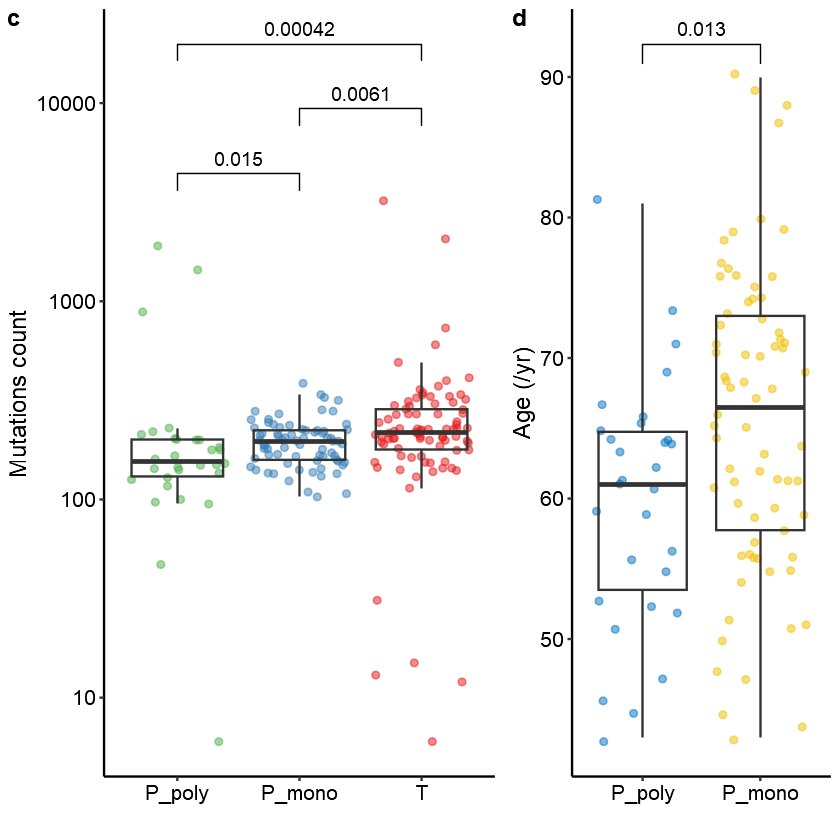

In [302]:
plot_grid(plotlist = list(p1,p2),rel_widths = c(1.5,1),ncol=2,labels = c('c','d'),label_fontface = 2)
ggsave("D:/2.crc_trio/draft/toZL/fig4_related/v2/fig4cd_r2.pdf",width = 5.5,height = 3)
dev.off()

In [303]:
dat %>% filter(purity>=0.25) %>% filter(grepl("P$",Sample)) %>% #filter(total_SNP>50) %>% 
group_by(Lineage) %>% dplyr::summarise(y=mean(Age))
dat %>% filter(purity>=0.25) %>% filter(grepl("P$",Sample)) %>% #filter(total_SNP>50) %>%
group_by(Lineage) %>% dplyr::count() %>% mutate(f=n/102) #5个样本purity<0.25

Lineage,y
<chr>,<dbl>
Monoclonal,65.58333
Polyclonal,59.83333


Lineage,n,f
<chr>,<int>,<dbl>
Monoclonal,72,0.7058824
Polyclonal,30,0.2941176


In [304]:
#fig4f,g

In [305]:
2/30

[1] 0.06666667

In [306]:
Top50_genestat %>% filter(derived =="T_Monoclonal") %>% arrange(desc(frac)) %>% head()

,Gene,derived,value,frac
,<fct>,<fct>,<dbl>,<dbl>
1,APC,T_Monoclonal,69,87.34
2,TP53,T_Monoclonal,61,77.22
3,KRAS,T_Monoclonal,32,40.51
4,FBXW7,T_Monoclonal,25,31.65
5,LRP1B,T_Monoclonal,15,18.99
6,PIK3CA,T_Monoclonal,13,16.46


In [30]:
#fig4f
t=Top50_genestat %>% filter(derived =="T_Monoclonal") %>% arrange(desc(frac))

p3=Top50_genestat %>% filter(Gene %in% setdiff(cutoff,ex_gene)) %>% 
dplyr::mutate(Gene=as.character(Gene),Gene=factor(Gene,levels=rev(as.character(t$Gene))),
       derived=as.character(derived),derived=factor(derived,levels=derived %>% unique() %>% rev() )
      ) %>%
ggplot(aes(x=Gene,y=frac)) + geom_bar(aes(fill=derived),stat="identity",position = 'dodge',alpha=0.8) +
  scale_fill_brewer(palette = 'Set1')+scale_y_continuous(breaks=seq(0,100,by=25),limits = c(0,100),position="right") +
  ylab("Percentage of patients")+xlab('')+
  theme_bw()+theme(panel.grid = element_blank(),
                   panel.border = element_blank(),
                   plot.title = element_text(hjust = 0.5))+
  theme(legend.position = c(0.9,0.2),
        legend.title  = element_text(size=10),
        legend.text = element_text(size=8),
        legend.key.size =unit(0.2,'cm') ) +
  theme(axis.text.x = element_text(size=8,colour = "black"),
        axis.ticks = element_line(size=0.4),
        axis.text.y = element_text(size=8,colour = "black",vjust = 0.5,hjust=1,face="italic"),
        axis.title = element_text(size=10,colour = "black"),
        axis.line = element_line(colour = "black",size=0.5)
  )+guides(fill = guide_legend(title = ""))+coord_flip() 

#fig4g
library(ggridges)
library(reshape2)
maf_top_snv=maf_driver_snv_all %>% filter(Tumor_Sample_Barcode %in% colnames(Top50_geneMatrix) ) %>% filter(Patient_ID != "B082" & Patient_ID != "B127") %>% filter(Hugo_Symbol %in% cutoff) %>% 
mutate(CCF_adj=ifelse(CCF_adj>1,1,CCF_adj),derived=dat[match(Tumor_Sample_Barcode,dat$Sample),'derived']) %>%  filter(derived!="T_Polyclonal") %>%
filter(! Hugo_Symbol %in% ex_gene) %>%
mutate(Hugo_Symbol=factor(Hugo_Symbol,levels = rev( setdiff( c('APC','SPTA1','ZFP36L2','TCF7L2','BCL9L','SMARCA4','FBXW7','CTNNB1','SOX9',
                                                     'KRAS','TP53','FAT4','FAT3','PCDH17','ARID1A','LRP1B','PIK3CA','SMAD4'),ex_gene) )) )
p4 <- maf_top_snv  %>% filter(Tumor_Sample_Barcode %in% colnames(Top50_geneMatrix) ) %>% filter(grepl("T$|P$",Tumor_Sample_Barcode) ) %>%
  ggplot(aes(x=CCF_adj,y=Hugo_Symbol,fill=derived))+
  geom_density_ridges(scale=2.95,point_size=0.25,alpha=0.4,color="white" #from=0,to=1.5,jittered_points=T,point_shape="|",point_size=3,position = position_points_jitter(height = 0)
            )+
  scale_y_discrete(expand = c(0.01,0),name="")+scale_x_continuous(expand = c(0,0),breaks = seq(0,1.5,by=0.5),name = "Cancer cell fraction")+
  scale_fill_brewer(palette = 'Set1',direction = -1)+
  theme_bw() +theme(panel.grid = element_blank(),
        panel.border=element_rect(colour = "black",size = 0.5),
        plot.title = element_text(hjust = 0))+
  theme(legend.position = "right",
        legend.text = element_text(size=8),
        legend.key.size =unit(0.2,'cm') ) +
  theme(axis.text.x = element_text(size=8,colour = "black"),
        axis.text.y = element_text(size=8,colour = "black",face="italic"),
        axis.ticks = element_line(size=0.5),
        axis.title = element_text(size=10,colour = "black"),
        axis.line = element_line(colour = "black",size=0.5)
  )
  

Warning message:
"The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
i Please use the `linewidth` argument instead."


Picking joint bandwidth of 0.0905



null device 
          1

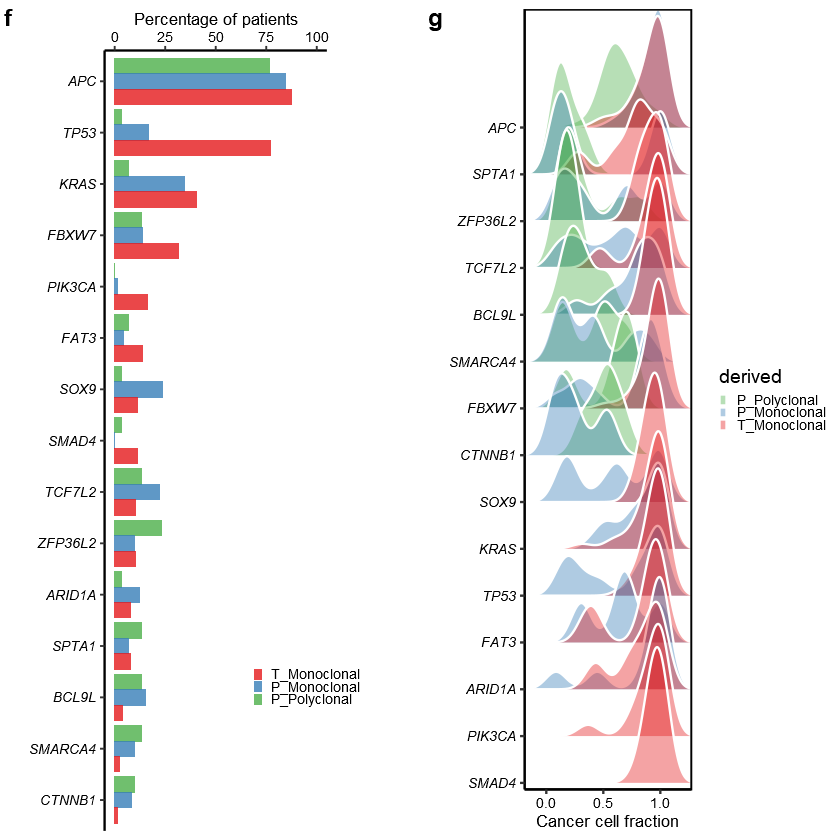

In [32]:
plot_grid(plotlist = list(p3,NULL,p4),ncol=3,rel_widths = c(0.8,0.2,1),labels = c('f','','g'),label_fontface = 2)
ggsave("D:/2.crc_trio/draft/toZL/fig4_related/v2/fig4fg_r3.pdf",width = 9,height = 6)
dev.off()

In [358]:
getwd()

[1] "D:/2.crc_trio/results"

## FigSx_dnds

In [17]:
ls()

[1] "bamdst"                 "covs"                   "cutoff"                
 [4] "dat"                    "gene_list"              "gr_genes"              
 [7] "known_cancergenes"      "ls_escc_af"             "maf"                   
[10] "maf_driver_snv_all"     "maindir"                "makeHeatmapAnnotations"
[13] "MutTable"               "path_refdb"             "plotCNVHeatmap"        
[16] "pm_ci"                  "pm_dndsout"             "pm_sg_dndsout"         
[19] "pm_site_out"            "populateCNVMatrix"      "pp_ci"                 
[22] "pp_dndsout"             "pp_sg_dndsout"          "pp_site_out"           
[25] "readMeta"               "readSeg"                "readSeg2"              
[28] "RefCDS"                 "sgWGS.df"               "sgWGS.maf"             
[31] "sgWGS.wes"              "sgWGS.wes.mp"           "sgWGS.wes.pp"          
[34] "substmodel"             "suppdir"                "tm_ci"                 
[37] "tm_dndsout"             "tm_site_out"            "Top50_driver"          
[40] "Top50_genedat"          "Top50_geneMatrix"       "tp_ci"                 
[43] "tp_dndsout"             "tp_site_out"            "tt"

In [30]:
sgWGS.wes.mp %>% filter(Hugo_Symbol == 'APC')
MutTable %>% filter(Hugo_Symbol == 'APC')

sampleID,chr,pos,ref,mut,Hugo_Symbol,Variant_Classification
<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>
B139P6_R5_G7,chr5,112827194,C,T,APC,Nonsense_Mutation


In [37]:
pp_dndsout$sel_loc %>% head()
pp_sg_dndsout$sel_loc %>% head()

,gene_name,n_syn,n_mis,n_non,n_spl,wmis_loc,wnon_loc,wspl_loc,pmis_loc,pall_loc,qmis_loc,qall_loc
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
840,APC,0,0,21,3,0,10000,10000,0.9999921,0.000000e+00,0.9999994,0.00000
1494,BCL9L,0,0,4,0,0,10000,0,0.9999922,1.204493e-06,0.9999994,0.01158
15516,SOX9,0,0,2,0,0,10000,0,0.9999942,1.222320e-03,0.9999994,1.00000
15176,SLC6A18,0,1,0,2,10000,0,10000,0.3364718,4.607665e-03,0.9999994,1.00000
4470,DNAJC25,0,0,0,1,0,0,10000,0.9999959,1.333239e-02,0.9999994,1.00000
12274,PLA2G15,0,0,0,1,0,0,10000,0.9999957,2.039107e-02,0.9999994,1.00000


,gene_name,n_syn,n_mis,n_non,n_spl,wmis_loc,wnon_loc,wspl_loc,pmis_loc,pall_loc,qmis_loc,qall_loc
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
840,APC,0,0,22,3,0,1.000000e+04,10000.00000,9.999917e-01,0.000000e+00,0.9999994,0.00000000
1494,BCL9L,0,0,4,0,0,1.000000e+04,0.00000,9.999918e-01,1.241857e-06,0.9999994,0.01193921
290,ADAMTS9,7,0,1,0,0,8.098611e-01,0.00000,5.756472e-05,6.670894e-04,0.9999994,1.00000000
15516,SOX9,0,0,2,0,0,1.000000e+04,0.00000,9.999939e-01,1.251422e-03,0.9999994,1.00000000
15839,ST13,1,0,0,2,0,0.000000e+00,16.08772,9.837395e-02,3.629368e-03,0.9999994,1.00000000
4362,DKK2,0,0,2,0,0,1.000000e+04,0.00000,9.999966e-01,8.567107e-03,0.9999994,1.00000000


In [36]:
pm_dndsout$sel_loc %>% head()
pm_sg_dndsout$sel_loc %>% head()

,gene_name,n_syn,n_mis,n_non,n_spl,wmis_loc,wnon_loc,wspl_loc,pmis_loc,pall_loc,qmis_loc,qall_loc
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
840,APC,0,1,56,3,1.000000e+04,10000.00000,10000.00000,0.4731673787,0.000000e+00,0.9999992,0.000000e+00
15516,SOX9,0,1,5,2,1.000000e+04,10000.00000,10000.00000,0.2913191812,3.095546e-11,0.9999992,2.976058e-07
1494,BCL9L,0,2,5,1,1.000000e+04,10000.00000,10000.00000,0.1834178965,1.571855e-07,0.9999992,1.007454e-03
8395,KRAS,0,27,0,0,1.000000e+04,0.00000,0.00000,0.0000162096,3.568825e-05,0.3116781,1.715534e-01
1006,ARID1A,1,1,4,0,5.577213e-01,42.77469,0.00000,0.6818066081,1.570525e-04,0.9999992,5.155456e-01
17176,TP53,1,5,3,3,1.984950e+00,19.46626,49.96888,0.5010114857,1.608734e-04,0.9999992,5.155456e-01


,gene_name,n_syn,n_mis,n_non,n_spl,wmis_loc,wnon_loc,wspl_loc,pmis_loc,pall_loc,qmis_loc,qall_loc
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
840,APC,0,1,57,3,1.000000e+04,10000.00000,10000.00000,4.717632e-01,0.000000e+00,0.9999992,0.000000e+00
15516,SOX9,0,1,5,2,1.000000e+04,10000.00000,10000.00000,2.910284e-01,3.098299e-11,0.9999992,2.978705e-07
1494,BCL9L,0,2,5,1,1.000000e+04,10000.00000,10000.00000,1.828778e-01,1.574823e-07,0.9999992,1.009356e-03
8395,KRAS,0,27,0,0,1.000000e+04,0.00000,0.00000,1.536406e-05,3.418368e-05,0.2954202,1.643210e-01
17176,TP53,1,5,3,3,1.996450e+00,19.51970,50.50886,4.971666e-01,1.579533e-04,0.9999992,5.077354e-01
1006,ARID1A,1,1,4,0,5.594018e-01,42.76798,0.00000,6.833358e-01,1.584362e-04,0.9999992,5.077354e-01


In [18]:
#dndsout_lists=list(pp_dndsout,pm_dndsout,tm_dndsout)
dndsout_lists=list(pp_sg_dndsout,pm_sg_dndsout,tm_dndsout)
names(dndsout_lists)=c("PP","PM","TM")

In [19]:
data(list = sprintf("covariates_%s", "hg19_hg38_epigenome_pcawg"), package = "dndscv")
path_refdb = system.file("data", "RefCDS_human_GRCh38.p12_dNdScv.0.1.0.rda", package = "dndscv", mustWork = TRUE)
path_refdb
load(path_refdb)

data(list = sprintf("RefCDS_human_%s", "GRCh38.p12_dNdScv.0.1.0"), package = "dndscv")
gene_list = intersect(sapply(RefCDS, function(x) x$gene_name),row.names(covs))  #为了保持refdp的基因要在covs中，不然会报错

[1] "C:/software/R/R-4.1.0/library/dndscv/data/RefCDS_human_GRCh38.p12_dNdScv.0.1.0.rda"

In [20]:
dnds_type_names = 
  type_names = c(
  "wmis" = "Missense",
  "wtru" = "Truncating",
  "wnon" = "Nonsense",
  "wspl" = "Splice-site"
)


gene_lists = c(
  "all_genes",
  "IntOGen-DriverGenes_COREAD",
  "IntOGen-DriverGenes_COREAD_sc_drivers_rm",
  "CRC_drivers_Cross2018_Tier1",
  "coad_driver_genes_tcga_2012",
  "driver_genes_martincorena_2017",
  "driver_genes_tarabichi_2018",
  "chromatin_modifers_selected",
  "chromatin_modifer_genes",
  "IntOGene_custom"
)

gene_lists = 
  THmisc::gene_lists[gene_lists] %>% 
  magrittr::set_names(gene_lists)

gene_lists$all_genes = 
  gene_lists$all_genes %>% 
  (function(x) x[!x %in% setdiff(gene_lists$all_genes,gene_list) ])

gene_lists$driver_genes_martincorena_2017 = 
  gene_lists$driver_genes_martincorena_2017 %>% 
  (function(x) x[!x %in% setdiff(gene_lists$driver_genes_martincorena_2017,gene_list) ])
   
#gene_lists$IntOGene_custom = "./runtime/CRC_driver_678.txt" %>% readr::read_table(col_names = F) %>% dplyr::select(X1) %>% unlist() 
gene_lists$IntOGene_custom = "D:/2.crc_trio/results/refdb/genelist/Colon_driver_genes.txt" %>% readr::read_table(col_names = T) %>% dplyr::select(Gene) %>% unlist() 
gene_lists$IntOGene_custom =
   gene_lists$IntOGene_custom %>% 
  (function(x) x[!x %in% setdiff(gene_lists$IntOGene_custom,gene_list) ])   

summary(gene_lists)


-- Column specification ------------------------------------------------------------------------------------------------
cols(
  Gene = col_character(),
  CancerType = col_character()
)



                                         Length Class  Mode     
all_genes                                18170  -none- character
IntOGen-DriverGenes_COREAD                  72  -none- character
IntOGen-DriverGenes_COREAD_sc_drivers_rm     0  -none- NULL     
CRC_drivers_Cross2018_Tier1                 15  -none- character
coad_driver_genes_tcga_2012                 37  -none- character
driver_genes_martincorena_2017             365  -none- character
driver_genes_tarabichi_2018                193  -none- character
chromatin_modifers_selected                  0  -none- NULL     
chromatin_modifer_genes                      0  -none- NULL     
IntOGene_custom                            340  -none- character

In [21]:
gene_set_labels = c(
  "all_genes" = "All",
  "IntOGen-DriverGenes_COREAD" = "IntOGen",
  "IntOGene_custom" = "CRC_drivers",
  "IntOGen-DriverGenes_COREAD_sc_drivers_rm" = "IntOGen (exc. subclonal drivers)",
  "CRC_drivers_Cross2018_Tier1" = "Cross et al. (2018)",
  "coad_driver_genes_tcga_2012" = "TCGA (2012)",
  "driver_genes_martincorena_2017" = "Martincorena et al. (2017)",
  "driver_genes_tarabichi_2018" = "Tarabichi et al. (2018)",
  "chromatin_modifers_selected" = "Chromatin modifiers (selected)",
  "Oncogene" = "Oncogenes",
  "TSG" = "TSG",
  "chromatin_modifer_genes" = "Chromatin modifiers (all)",
  "chromatin_modifer_genes_reactome" = "Chromatin modifiers (Reactome)"
)

In [22]:
#keyset=c("all_genes","IntOGen-DriverGenes_COREAD","driver_genes_martincorena_2017")
keyset=c("all_genes","IntOGene_custom") ##去掉"driver_genes_martincorena_2017"
globaldnds=NULL
for(i in 1:length(dndsout_lists) ){    
    for(j in 1:length(keyset)){
        geneset_dnds=genesetdnds(dndsout_lists[[i]],gene_list = gene_lists[[ keyset[j] ]])
        tmpdnds=data.frame(name=gsub("_geneset","",rownames(geneset_dnds$globaldnds_geneset) ),geneset_dnds$globaldnds_geneset)
        tmpdnds$derived=names(dndsout_lists)[i]
        tmpdnds$geneset=keyset[j]
        globaldnds=rbind(globaldnds,tmpdnds)
    }
    

}

genesets = c("All","CRC_drivers") #,"Martincorena et al. (2017)"
cols = c("#e63946","#457b9d") #,"#83c5be"

d_cur_m = globaldnds %>% filter(derived != "P") %>% 
dplyr::filter(name %in% c("wmis","wtru","wnon")) %>% 
dplyr::mutate(name = dnds_type_names[match(name,names(dnds_type_names))] ) %>%
dplyr::filter(geneset %in% names(gene_set_labels) ) %>%
dplyr::mutate(geneset = gene_set_labels[match(geneset,names(gene_set_labels))] ) %>%
dplyr::mutate(variant_group=factor(derived, levels = c("PP","PM","TM")) )  %>% 
dplyr::mutate(x_pos = as.numeric(variant_group)) %>%
dplyr::mutate(gene_set_label = factor(geneset,levels = genesets ) ) %>%
dplyr::mutate(x_offset = as.numeric(gene_set_label)) %>%
dplyr::mutate(x_offset = ((x_offset - 1) - (length(levels(gene_set_label)) - 1) / 2) / (length(levels(gene_set_label))) / 2) 
levels(d_cur_m$variant_group) = c("P_poly", "P_mono","T_mono") 

In [23]:
levels(d_cur_m$variant_group) = c("P_poly", "P_mono","T_mono") 

In [39]:
p6=d_cur_m %>%
ggplot(aes(x=x_pos+x_offset,
           y=mle,ymin=cilow,ymax=cihigh,color=gene_set_label,group=gene_set_label))+geom_pointrange(size=0.1)+
  xlab("")+ylab("dN/dS")+scale_y_log10(limits = c(0.1,100))+
  scale_x_continuous(breaks=seq_along(levels(d_cur_m$variant_group)), labels=levels(d_cur_m$variant_group)) +
  geom_hline(yintercept = 1,lty = 2)+
  scale_color_npg()+
  theme_bw() +theme(panel.grid = element_blank(),
        panel.border=element_blank(),
        plot.title = element_text(hjust = 0))+
  guides(color = guide_legend(title="Genes")) +
  theme(legend.position = "bottom",
        legend.title  = element_text(size=8),
        legend.text = element_text(size=8),
        panel.spacing=unit(1,'cm'),
        legend.key.size =unit(0.2,'cm') ) +
  theme(
        axis.text = element_text(size=10,colour = "black"),
        axis.ticks = element_line(size=0.8),
        axis.line = element_line(colour = "black",size = 0.5)) +
  facet_grid(~name, scales="free_x",space='free')+
  theme(
        strip.background = element_blank(),
        strip.text.x = element_text(angle=0,size=8,colour = "black") )+  #,face = "bold.italic"
  coord_cartesian(clip = 'off') + 
  scale_alpha_identity()    



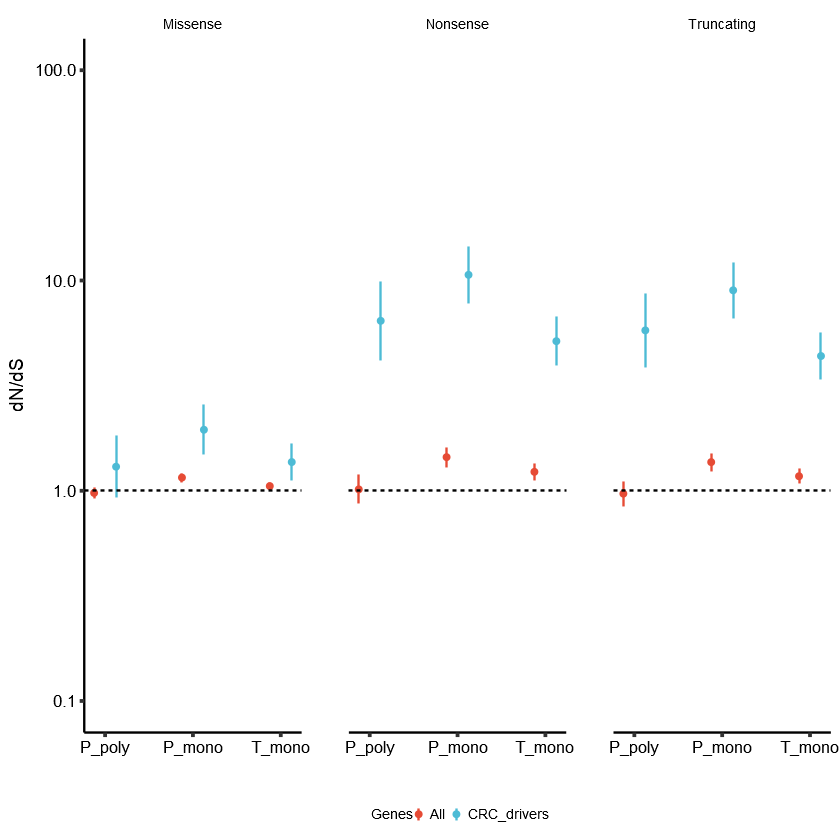

In [40]:
print(p6)


null device 
          1

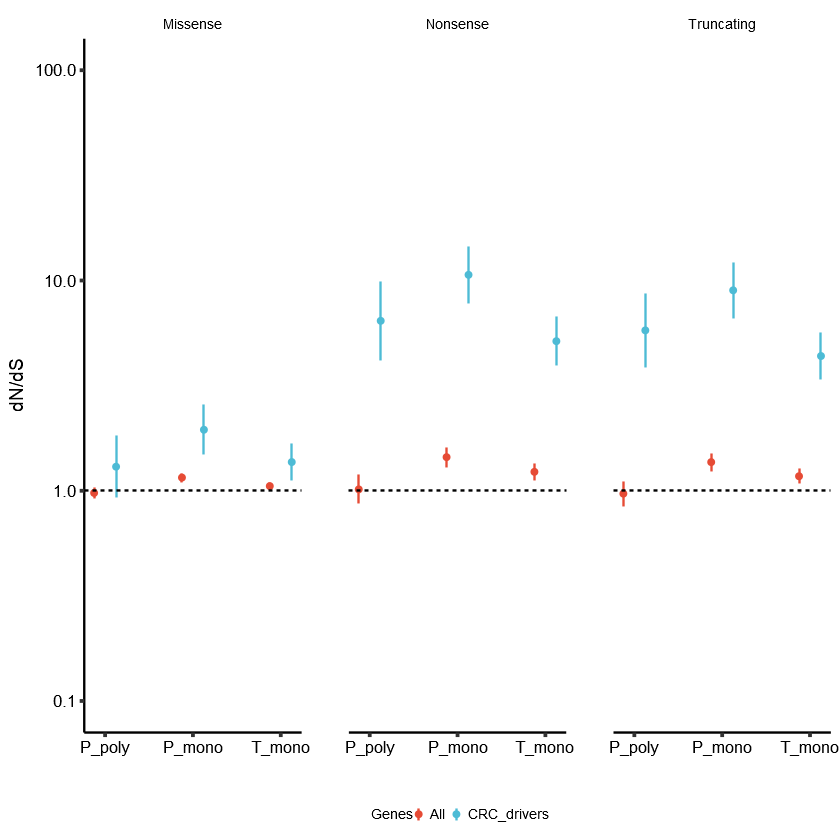

In [41]:
print(p6)
ggsave("D:/2.crc_trio/draft/toZL/fig4_related/v2/figS25_dnds_r3.pdf",width = 5,height = 3)
dev.off()

## fig4e_cnv

In [85]:
dat %>% colnames()

[1] "Patient"                     "Sample"                     
 [3] "Clonal"                      "Subclonal"                  
 [5] "ClonalSNP"                   "SubclonalSNP"               
 [7] "Frame_Shift_Del"             "Frame_Shift_Ins"            
 [9] "In_Frame_Del"                "In_Frame_Ins"               
[11] "Missense_Mutation"           "Nonsense_Mutation"          
[13] "Nonstop_Mutation"            "Splice_Site"                
[15] "Translation_Start_Site"      "total_nonsilent"            
[17] "NonSilent_SNV"               "total_SNP"                  
[19] "total_DEL"                   "total_INS"                  
[21] "total_MNP"                   "TMB"                        
[23] "derived"                     "ClonalDriver"               
[25] "SubDriver"                   "TotalDriver"                
[27] "Total_Number_of_Sites"       "Number_of_Somatic_Sites"    
[29] "MSIscore"                    "MSItype"                    
[31] "dmmr"                        "HLA_Loss"                   
[33] "HLA_Loss_Allele_Counts"      "purity"                     
[35] "ploidy"                      "depth"                      
[37] "neo_clonal"                  "neo_subclonal"              
[39] "neo_clonal_ccf"              "TCRA.cn"                    
[41] "TCRA.tcell.fraction"         "TCRA.tcell.fraction.lwr"    
[43] "TCRA.tcell.fraction.upr"     "TCRA.tcell.fraction.adj"    
[45] "TCRA.tcell.fraction.adj.lwr" "TCRA.tcell.fraction.adj.upr"
[47] "highTcellFlag"               "AMP"                        
[49] "DEL"                         "FLA"                        
[51] "Age"                         "Lineage"                    
[53] "wGII"                        "CIN_status"                 
[55] "Clonal_CCF_Mean"

Using Sample, derived as id variables



null device 
          1

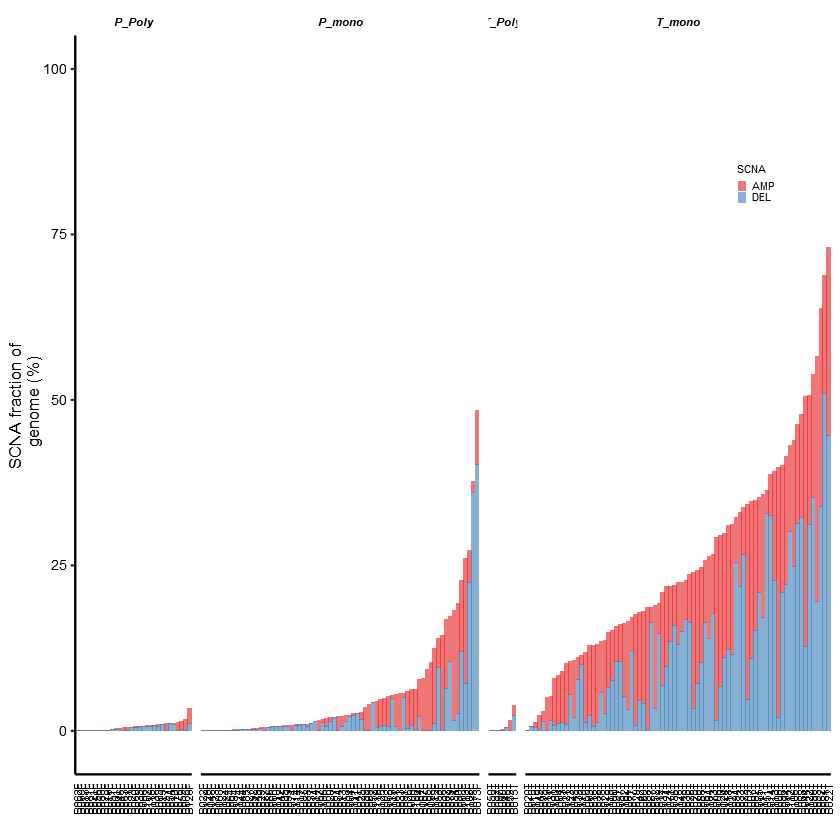

In [86]:
p5<- dat %>% filter(purity>=0.25) %>% filter(grepl("T$|P$",Sample))%>% 
dplyr::mutate(derived=as.character(derived),
       derived=factor(derived,levels=c("P_Polyclonal","P_Monoclonal","T_Polyclonal","T_Monoclonal") ) ) %>% 
arrange(derived,FLA,AMP) %>% mutate(Sample=factor(Sample,levels=unique(Sample) ) ) %>%
dplyr::select(Sample,AMP,DEL,derived) %>% reshape2::melt() %>% dplyr::rename(c("Frac"="value","SCNA"="variable"))%>%
  ggplot( aes(x=Sample,y=Frac,fill=SCNA))+geom_bar(stat="identity",position = 'stack',alpha=0.6) +ylim(-1.5,100)+
  scale_fill_brewer(palette = 'Set1')+ylab("SCNA fraction of \n genome (%)")+xlab('')+
  facet_grid(~derived,scales = "free_x",space = "free_x",labeller =as_labeller(c('P_Polyclonal'='P_Poly','P_Monoclonal'='P_mono','T_Polyclonal'='T_Poly','T_Monoclonal'='T_mono')) )+
  theme_bw()+theme(panel.grid = element_blank(),
                   panel.border = element_blank(),
                   plot.title = element_text(hjust = 0.5))+
  theme(legend.position = c(0.9,0.8),
        legend.title  = element_text(size=6),
        legend.text = element_text(size=6),
        legend.key.size =unit(0.2,'cm') ) +
  theme(axis.text.x = element_text(size=6,colour = "black",angle = 90,vjust = 0.5),
        axis.ticks.x = element_blank(),
        axis.text.y = element_text(size=8,colour = "black"),
        axis.ticks.y = element_line(size=0.5),
        axis.title = element_text(size=10,colour = "black"),
        axis.line = element_line(colour = "black",size=0.5)
  )+theme(strip.background = element_blank(),
   strip.text.x = element_text(size=6,colour = "black",face = "bold.italic") )+
guides(fill = guide_legend(title = "SCNA")) #+geom_rug(sides="b",aes(color=derived))+scale_color_brewer(palette = 'Set1',direction = -1) #geom_tile(aes(x=ID,y=-1,fill=derived)) #
print(p5)
ggsave("D:/2.crc_trio/draft/toZL/fig4_related/v2/fig4e_u.pdf",width = 12,height = 3)
dev.off()

In [261]:
## cnv landscape

In [87]:
# Chromosome sizes, for binning and plotting coordinates
binGenome <- function(chromSizesPath){
  chromCoords <- read.csv(chromSizesPath, sep="\t", stringsAsFactors = FALSE, header = FALSE, col.names = c("chr", "size"))
  chromCoords$chr <- gsub("chr", "", chromCoords$chr)
  chromCoords$start <- cumsum(as.numeric(c(1,chromCoords$size[1:nrow(chromCoords)-1])))
  chromCoords$cumsum <- cumsum(as.numeric(chromCoords$size))
  chromCoords$color <- ifelse(c(1:length(chromCoords$chr))%%2 ==0, yes="black", no="gray")
  chromCoords
}


hg38.genome.sizes <- "D:/2.crc_trio/src/cnv-heatmap-master/data/hg38.chrom.exclued.XY.sizes.txt"
chromCoordsHg38 <- binGenome(hg38.genome.sizes)

chromCoordsHg38[1:2,]

,chr,size,start,cumsum,color
,<chr>,<int>,<dbl>,<dbl>,<chr>
1,1,248956422,1,248956422,gray
2,2,242193529,248956423,491149951,black


In [89]:
seg_raw=read.table('./7.gistic2/CRC_SCNA_segs.txt',header = T,sep="\t")
seg=seg_raw %>% filter(grepl("P$|T$",ID)) %>% filter(ID %in% dat$Sample[which(dat$purity>=0.25)]) %>% dplyr::select(ID,chrom,loc.start,loc.end,num.mark,seg.mean.adj)
seg<-readSeg2(seg,chromCoordsHg38)

In [90]:
coords <- chromCoordsHg38
rownames(coords)=coords$chr
coordMat <- do.call(rbind, lapply(coords$chr,
                      function(i) {chr.i <- subset(coords, chr==i);
                      return(data.frame(row=seq(chr.i$start, chr.i$cumsum, by=100000), chr=i))}))
coordMat$chr=factor(coordMat$chr,levels=unique(coordMat$chr))

coordMat[1:2,]
levels(coordMat$chr)

,row,chr
,<dbl>,<fct>
1,1,1
2,100001,1


[1] "1"  "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10" "11" "12" "13" "14" "15"
[16] "16" "17" "18" "19" "20" "21" "22"

In [91]:
samples <- unique(seg$Sample)
cnvMat <- matrix(rep(rep(0,nrow(coordMat)),length(samples)),ncol=length(samples))
colnames(cnvMat) <- samples
populate.binned.data <- function(start, end, column, value){ cnvMat[(start/100000):(end/100000), column] <<- value}

In [92]:
cnvMat <- populateCNVMatrix(chromCoords = coords,
                              coordMat = coordMat,
                              segDf = seg)

cnvMat[1:6,]
dim(cnvMat)

,B001P,B001T,B002P,B002T,B003P,B004P,B004T,B005P,B006P,B006T,...,B120T,B122P,B122T,B123P,B123T,B124P,B124T,B125P,B126P,B126T
1,-0.259,-0.961,-0.312,0.564,0.169,-0.069,0.557,0.003,-0.583,0.064,...,0.379,0.381,0.874,-0.269,-0.498,0.021,-0.702,-0.161,0.135,0.419
1,-0.259,-0.961,-0.312,0.564,0.169,-0.069,0.557,0.003,-0.583,0.064,...,0.379,0.381,0.874,-0.269,-0.498,0.021,-0.702,-0.161,0.135,0.419
1,-0.259,-0.961,-0.312,0.564,0.169,-0.069,0.557,0.003,-0.583,0.064,...,0.379,0.381,0.874,-0.269,-0.498,0.021,-0.702,-0.161,0.135,0.419
1,-0.259,-0.961,-0.019,0.564,-0.036,-0.069,0.557,0.003,-0.583,0.064,...,0.379,0.381,0.874,-0.015,0.119,0.021,-0.702,-0.161,0.135,0.419
1,0.078,-0.554,-0.019,0.564,-0.036,-0.069,0.557,0.003,-0.049,0.064,...,0.379,0.359,0.874,-0.015,0.119,0.021,-0.702,-0.152,-0.069,-0.136
1,0.078,-0.554,-0.019,0.564,-0.036,-0.069,0.557,0.003,-0.049,0.064,...,0.379,0.359,0.874,-0.015,0.119,0.021,-0.702,-0.152,-0.069,-0.136


[1] 28760   188

In [93]:
left_chr<-left_join(coordMat,coords[,c('chr','color')],by="chr")
left_chr=as.matrix(left_chr)
rownames(left_chr)<-left_chr[,2]

left_chr %>% head()

,row,chr,color
1,1,1,gray
1,100001,1,gray
1,200001,1,gray
1,300001,1,gray
1,400001,1,gray
1,500001,1,gray


In [94]:
cnv_anno<-dat %>% filter(purity>=0.25) %>% filter(grepl("T$|P$",Sample))%>% 
dplyr::mutate(derived=as.character(derived),derived=factor(derived,
                      levels=c("P_Polyclonal","P_Monoclonal","T_Polyclonal","T_Monoclonal") ) ) %>% arrange(derived,FLA,AMP) %>% 
mutate(Sample=factor(Sample,levels=unique(Sample)),Type=substr(Sample,5,5)) %>% 
dplyr::select(Sample,derived,Type,Lineage,ploidy,wGII,CIN_status)

In [95]:
cnv_anno %>% head(n=2)

,Sample,derived,Type,Lineage,ploidy,wGII,CIN_status
,<fct>,<fct>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,B062P,P_Polyclonal,P,Polyclonal,1.97,0.02318182,CIN-
2,B069P,P_Polyclonal,P,Polyclonal,2.01,0.04363636,CIN-


In [96]:
p5_d<-Heatmap(cnvMat[,match(cnv_anno$Sample,colnames(cnvMat))], 
              cluster_columns = FALSE,
              cluster_rows = FALSE,
              show_row_names = FALSE,
              #row_order=order(as.numeric(rownames(cnvMat))),
              #column_order=dat$ID,
              column_split=cnv_anno$derived,
              row_split = coordMat$chr,
              column_names_gp = gpar(fontsize = 8),
              left_annotation = rowAnnotation(chr=left_chr[,'color'],
                                              col=list(chr=c('black'='black','gray'='gray')),
                                              annotation_legend_param = list(title=""),
                                              simple_anno_size = unit(0.3, "cm")),
              
              bottom_annotation = HeatmapAnnotation(Type = cnv_anno$Type, 
                                                    Clonality=cnv_anno$Lineage,
                                                    Ploidy=cnv_anno$ploidy,
                                                    wGII=cnv_anno$wGII,
                                                    CIN=cnv_anno$CIN_status,
                                                simple_anno_size = unit(0.5, "cm"), 
                                                annotation_name_side="left",
                                                col=list(Type=c('T'='#E41A1C','P'='#377EB8'),
                                                         Clonality=c('Polyclonal'='#FC8D62','Monoclonal'='#66C2A5'),
                                                         Ploidy=circlize::colorRamp2(c(0,5),c("white","#309CB6")),
                                                         wGII=circlize::colorRamp2(c(0,100),c("white","#A1094B")),
                                                         CIN=c('CIN+'='#E64B35FF','CIN-'='#4DBBD5FF')
                                                        ),
                                                annotation_legend_param = list(title_position="leftcenter",
                                                                               direction="horizontal",nrow=1)                                         
                                                ),
              col = colorRamp2(c(-2, 0, 2), c("blue3", "white", "red3")),
              heatmap_legend_param = list( legend_direction = "horizontal", title_position = "lefttop"),
              name = "seg.mean")

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.



In [97]:
pdf("D:/2.crc_trio/draft/toZL/fig4_related/v2/fig4e_d.pdf",width=12,heigh=12)
draw(p5_d, heatmap_legend_side = "bottom",annotation_legend_side="bottom")
dev.off()

png 
  2

# SupplementaryFigure

In [ ]:
##relatedness between p and T, added two published wes data refered from 

In [ ]:
load(file="D:/2.crc_trio/draft/toZL/fig4_related/PT_relatedness.RData")

In [98]:
s13a<-rls %>% dplyr::group_by(patient) %>% 
dplyr::summarize(mean_scores=round(mean(pair_scores) ,5)) %>% 
mutate(Cohort=ifelse(grepl("^B",patient),"Polyp-CRC","Li J et al(2019)" ),
       Cohort=factor(Cohort) ) %>%
  ggplot(aes(x=patient,y=mean_scores))+geom_bar(stat="identity",position = 'stack',fill="#E55709",alpha=0.7) +
  scale_fill_brewer(palette = 'Set1')+geom_hline(yintercept=0.1, linetype=5, color = "black", size=0.5)+
  ylab("Clonal relatedness score")+xlab('')+ facet_grid(~Cohort,scales = "free_x",space = "free_x")+
  scale_y_continuous(breaks=seq(0,1,by=0.25), limits=c(0,1.0))+
  theme_bw()+theme(panel.grid = element_blank(),
                   panel.border = element_blank(),
                   plot.title = element_text(hjust = 0.5))+
  theme(legend.position = "none",
        legend.title  = element_text(size=14),
        legend.text = element_text(size=12),
        legend.key.size =unit(0.2,'cm') ) +
  theme(axis.text.x = element_text(size=6,colour = "black",angle = 90,vjust = 0.5),
        axis.ticks.x = element_line(size=0.4),
        axis.text.y = element_text(size=6,colour = "black"),
        axis.ticks.y = element_line(size=0.8),
        axis.title = element_text(size=8,colour = "black"),
        axis.line = element_line(colour = "black",size=0.5)
  )

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."


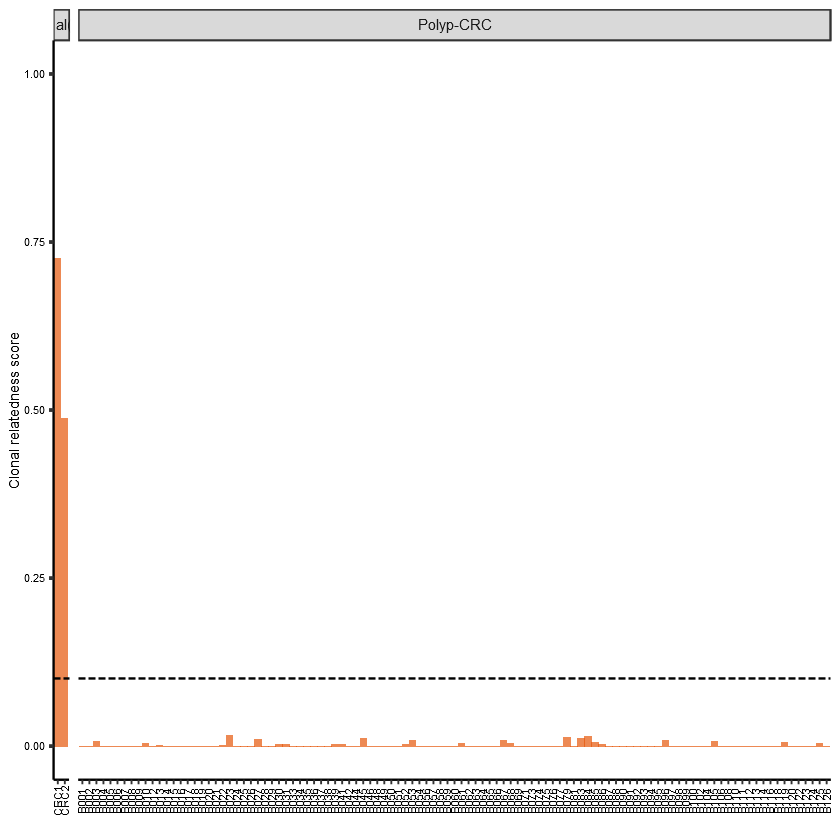

In [99]:
print(s13a)

In [100]:
summary(maf_top30_snv$CCF_adj)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0810  0.6900  0.9310  0.7999  1.0000  1.0000 

In [52]:
driverGene<-read.table("./runtime/CRC_driver_678.txt",header=F,sep="\t")
colnames(driverGene)='gene'
fun_cls=c("Missense_Mutation","Nonsense_Mutation","Nonstop_Mutation","Splice_Site","In_Frame_Ins","In_Frame_Del","Frame_Shift_Del","Frame_Shift_Ins")
clin<-read.xlsx("./0.库检/7.肠镜标本病理.xlsx",sheet = 1,colNames = T,cols = c(1:31))
clin<-clin %>% mutate(T=gsub(";n2","",T_site),P=gsub(";n2","",P_site))

pts=unique(dat$Patient)
sta=list()
ccf=list()
for (n in 1:length(pts)) {
    comb=NULL
    sn=dat$Sample[which(dat$Patient==pts[n])]
    for (i in sn) {
        tmp=ls_escc_af[[i]]
        tmp=tmp[which(tmp$Clonality!='Unknown'),]
        tmp=tmp[which(tmp$Alt_allele_depth>=5 & tmp$Total_allele_depth>=10),c(1:5,7,12,8,grep("CCF_adj",names(tmp)))]
        colnames(tmp)[9]=i
        if(is.null(comb)){
            comb=tmp
         }else{
            comb=dplyr::full_join(comb,tmp,by=c(colnames(tmp)[1:8]))
        }     
    }
    
     if(length(sn)>1){
         comb[,9:ncol(comb)]=apply(comb[,9:ncol(comb)],2,function(x){ x[which(is.na(x))]=0; x})
         LP=apply(as.data.frame(comb[,which(names(comb) %in% sn[grep("P",sn)])]/2),1,function(x){length(which(x>0.04))})
         LT=apply(as.data.frame(comb[,which(names(comb) %in% sn[grep("T",sn)])]/2),1,function(x){length(which(x>0.04))})
         idx=apply(comb[,9:ncol(comb)]/2,1,function(x){paste0("private=",names(x)[which(x>0.04)],collapse = ",")})
         if(length(LP)==0) LP=0
         if(length(LT)==0) LT=0
         comb$PubOrSub=ifelse(LP>=1 & LT>=1, "public", idx)
         pubidx=which(comb$PubOrSub=="public")
        }
    
    comb=comb %>% mutate(labels=paste0(Hugo_Symbol,aaChange),
                labels=ifelse(grepl(paste(driverGene$gene,collapse = "|"),Hugo_Symbol),labels,''),
                labels=ifelse(grepl(paste(fun_cls,collapse = "|"),Variant_Classification),labels,''),
                top_labs=ifelse(grepl(paste(Top50_driver[1:20],collapse = "|"),Hugo_Symbol),labels,'')        
                    )
    sta[[pts[n]]]=comb
    ccf[[pts[n]]]=as.data.frame(comb[,sn])
}


In [63]:
## Figure S13
pairs_plot=list()
j=0
for(i in c(7,1,24)){ #length(sta)
     #i=1
     gg=sta[[i]]
     gg$P=gg[,grep('P$',colnames(gg))]
     gg$T=gg[,grep('T$',colnames(gg))]
     j=j+1
     pairs_plot[[j]]<-gg %>% mutate(P=ifelse(P>1,1,P),T=ifelse(T>1,1,T)) %>% ggplot(aes(x=P,y=T)) +
     stat_density2d(aes(fill = ..density..), geom = "tile", contour = FALSE, n = 300) +
     scale_fill_continuous(low = "white", high = "#e55709")+geom_point(color="grey",shape=21,size=0.5)+labs(subtitle=names(sta[i])) +
     xlab(paste0('CCF in polyp','\n','(',clin[which(clin$PatientID==names(sta[i])),'P'],')'))+
     ylab(paste0('CCF in tumor','\n','(',clin[which(clin$PatientID==names(sta[i])),'T'],')'))+
     scale_x_continuous( breaks=c(0,0.25,0.5,0.75,1), labels=c('0.00','0.25','0.50','0.75','1.00'), limits=c(-0.1,1.1))+
     scale_y_continuous( breaks=c(0,0.25,0.5,0.75,1), labels=c('0.00','0.25','0.50','0.75','1.00'), limits=c(-0.1,1.1))+
     theme_classic() + 
     theme(legend.position = 'none',
             plot.subtitle = element_text(size=10,colour = "black"),
             axis.text = element_text(size=6,colour = "black"),
             axis.ticks = element_line(size=0.8),
             axis.title = element_text(size=8,colour = "black"),
             axis.line = element_line(colour = "black",size=0.5)
     )+geom_text_repel(aes(label=top_labs,fontface=3),size=1.8,min.segment.length = 0, seed = 42,box.padding = 0.5, max.overlaps = Inf)
}

Warning message:
"Removed 1196 rows containing missing values (`geom_tile()`)."
Warning message:
"Removed 1196 rows containing missing values (`geom_tile()`)."
Warning message:
"Removed 1196 rows containing missing values (`geom_tile()`)."


null device 
          1

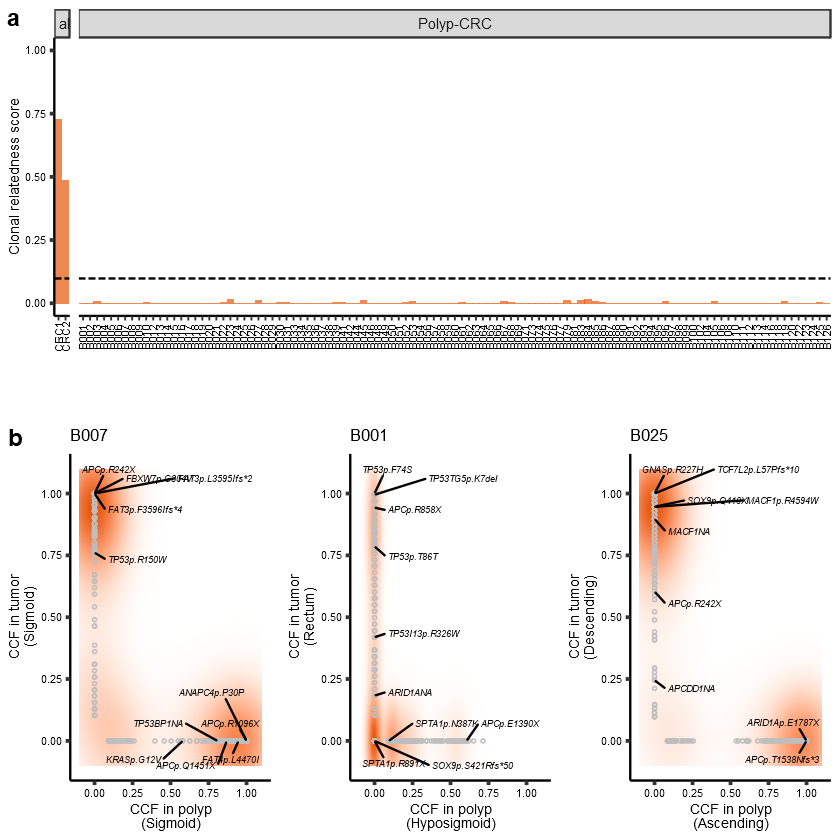

In [73]:
plot_grid(s13a,NULL,plot_grid(plotlist = pairs_plot,nrow = 1),
          ncol=1,labels = c('a','','b'),label_fontface = 2,rel_heights=c(0.9,0.1,1)
)
ggsave("D:/2.crc_trio/draft/toZL/fig4_related/v2/figS13.pdf",width = 10,height = 6)
dev.off()

null device 
          1

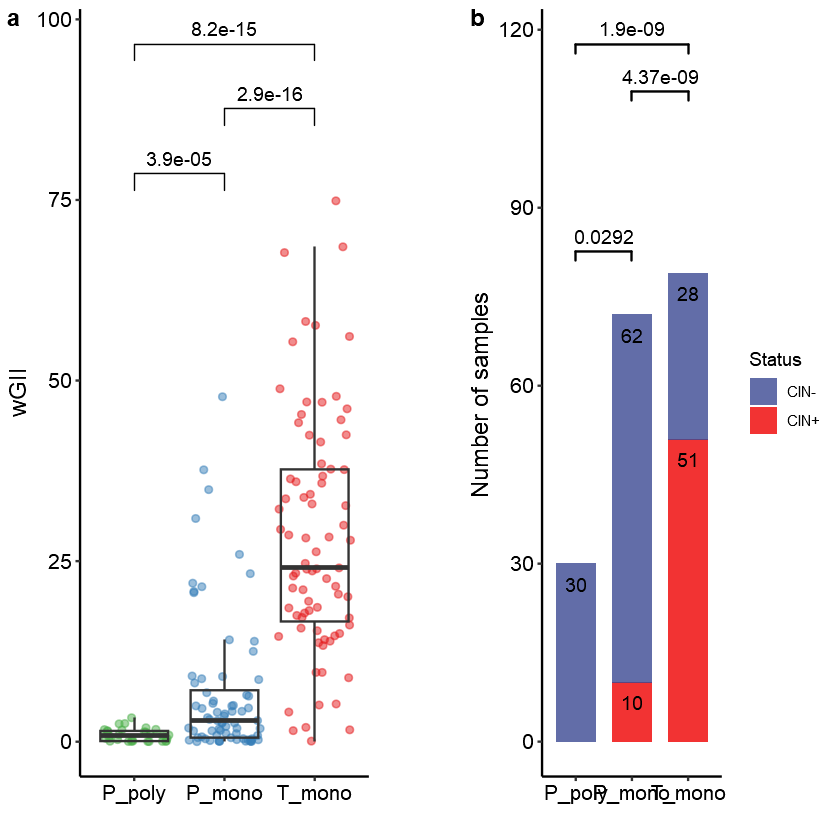

In [101]:
#2. Figure S15, wGII
s16a<-dat %>% filter(purity>=0.25) %>% filter(grepl("P$|T$",Sample)) %>% filter(derived!="T_Polyclonal") %>%
    ggplot(aes(x=derived,y=wGII)) + geom_jitter(aes(color=derived),alpha=.5) + geom_boxplot(outlier.shape = NA,fill=NA)+  
scale_color_brewer(palette = "Set1",direction = -1)+xlab("")+ylab("wGII")+
  stat_compare_means(comparisons=list(c("P_Monoclonal","P_Polyclonal"),
                                      c("P_Monoclonal","T_Monoclonal"),
                                      c("P_Polyclonal","T_Monoclonal")
                                      ),label = "p.format",label.x = 1.3)+
mytheme+scale_x_discrete(breaks=c("P_Polyclonal","P_Monoclonal","T_Monoclonal"), labels=c('P_poly','P_mono','T_mono'))

pVal1=fisher.test(matrix(c(0,28,11,68),nrow = 2),alternative = "less") # p_poly vs p_mono
pVal2=fisher.test(matrix(c(0,28,60,47),nrow = 2),alternative = "less") # p_poly vs t_mono
pVal3=fisher.test(matrix(c(11,68,60,47),nrow = 2),alternative = "less") # p_mono vs t_mono

s16b<-dat %>%filter(purity>=0.25) %>% filter(grepl("P$|T$",Sample)) %>% filter(derived!="T_Polyclonal") %>% 
dplyr::group_by(derived,CIN_status) %>% dplyr::count() %>% as.data.frame %>%  dplyr::rename(c("Sample"="n")) %>%
ggbarplot(x = "derived",y = "Sample",label = TRUE,lab.pos = "in" ,xlab = "",fill = "CIN_status",color = NA,alpha=0.8)+
  scale_fill_aaas()+
  ylab("Number of samples")+xlab('')+
  stat_signif(comparisons = list(c("P_Polyclonal","P_Monoclonal")),annotations =signif(pVal1$p.value,3) ,y_position = 80)+
  stat_signif(comparisons = list(c("P_Monoclonal","T_Monoclonal")),annotations =signif(pVal2$p.value,3) ,y_position = 107)+
  stat_signif(comparisons = list(c("P_Polyclonal","T_Monoclonal")),annotations =signif(pVal3$p.value,3) ,y_position = 115)+
theme_bw()+theme(panel.grid = element_blank(),
                   panel.border= element_blank(),
                   plot.title = element_text(hjust = 0.5))+
mytheme+scale_x_discrete(breaks=c("P_Polyclonal","P_Monoclonal","T_Monoclonal"), labels=c('P_poly','P_mono','T_mono'))+
theme(legend.position = "right")+guides(fill = guide_legend(title = "Status"))


plot_grid(plotlist = list(s16a,NULL,s16b),rel_widths = c(0.9,0.2,0.9),ncol=3,labels = c('a','','b'),label_fontface = 2)
ggsave("D:/2.crc_trio/draft/toZL/fig4_related/v2/figS16.pdf",width = 8,height = 4)
dev.off()

## sfs pattern ammong P and T

In [318]:
ls_escc_af[[1]] %>% head(n=2)
ls_escc_af[[1]] %>% colnames()

,Chromosome,Start_Position,End_Position,Reference_Allele,Tumor_Seq_Allele2,Tumor_Sample_Barcode,Hugo_Symbol,Variant_Classification,tx,exon,...,ExAC_AFR,ExAC_AMR,ExAC_EAS,ExAC_FIN,ExAC_NFE,ExAC_OTH,ExAC_SAS,esp6500siv2_all,Clonality,Patient_ID
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,1,1294511,1294511,C,T,B001P,ACAP3,Missense_Mutation,NM_030649,exon21,...,NA,NA,NA,NA,NA,NA,NA,NA,Subclonal,B001
2,1,7777276,7777276,C,A,B001P,VAMP3,Missense_Mutation,NM_004781,exon3,...,NA,NA,NA,NA,NA,NA,NA,NA,Unknown,B001


[1] "Chromosome"             "Start_Position"         "End_Position"          
 [4] "Reference_Allele"       "Tumor_Seq_Allele2"      "Tumor_Sample_Barcode"  
 [7] "Hugo_Symbol"            "Variant_Classification" "tx"                    
[10] "exon"                   "txChange"               "aaChange"              
[13] "Variant_Type"           "sample_id"              "Func.refGene"          
[16] "Gene.refGene"           "GeneDetail.refGene"     "ExonicFunc.refGene"    
[19] "AAChange.refGene"       "B001N_cover"            "B001N_alt_freq"        
[22] "Total_allele_depth"     "VAF"                    "Ref_allele_depth"      
[25] "Alt_allele_depth"       "CCF"                    "CCF_adj"               
[28] "CCFa_upper"             "LOH"                    "n_total"               
[31] "n_minor"                "n_major"                "mvalue"                
[34] "avsnp150"               "X1000g2015aug_all"      "cosmic70"              
[37] "ExAC_ALL"               "ExAC_AFR"               "ExAC_AMR"              
[40] "ExAC_EAS"               "ExAC_FIN"               "ExAC_NFE"              
[43] "ExAC_OTH"               "ExAC_SAS"               "esp6500siv2_all"       
[46] "Clonality"              "Patient_ID"

In [103]:
 ##a. polyps
  ## p-sfs
 n=grep("P$",names(ls_escc_af))
 tmp=do.call("rbind", lapply(ls_escc_af[n], function(x) {colnames(x)[20:21]=c('N_cover','N_alt_freq'); x }) )
 tmp=tmp[which(tmp$Alt_allele_depth>=5 & tmp$Total_allele_depth>=10),] #Tumor_Sample_Barcode
 tmp$vaf_adj=tmp$CCF_adj/2
 tmp=tmp[which(tmp$Clonality!='Unknown'),]
 tmp$type=tmp$Clonality
 sfs_pp=tmp %>% filter(Tumor_Sample_Barcode %in% (dat %>% filter(purity>=0.25) %>% filter(Lineage=="Polyclonal" & grepl("P$",Sample)) %>% dplyr::select(Sample) %>% t() %>% as.vector() ) ) %>% 
 ggplot(aes(x=vaf_adj,y=Tumor_Sample_Barcode,fill=stat(x) ))+
   geom_density_ridges_gradient(scale = 0.9, size = 0.3, rel_min_height = 0.01)+
   scale_fill_viridis_c(name = "vaf_adj", option = "C")+
   theme_ridges(font_family = "Roboto Condensed", grid = F)+
   facet_wrap(~Tumor_Sample_Barcode,scales="free_y",ncol=6)+
     guides(fill = guide_legend(title = "")) + 
     labs(
       x = "Cancer cell fraction",
       y = "density"
     ) +mobster:::my_ggplot_theme()+theme_classic()+
   theme(legend.position = "none",axis.text.y = element_text(angle = 90,hjust = 0),axis.ticks.y = element_blank(),strip.background = element_rect(color = "white", fill = "white"),panel.grid = element_blank(),strip.text = element_blank() )+
   geom_vline(xintercept=0.5, linetype=5, color = "black", size=0.5)+scale_x_continuous(breaks=c(0,0.25,0.50,0.75,1.00),labels=c("0.00","0.50","1.00","1.50","2.00"),limits = c(0,1))

 sfs_mp=tmp %>% filter(Tumor_Sample_Barcode %in% (dat %>% filter(purity>=0.25) %>% filter(Lineage=="Monoclonal" & grepl("P$",Sample)) %>%  dplyr::select(Sample) %>% t() %>% as.vector() ) ) %>% 
 ggplot(aes(x=vaf_adj,y=Tumor_Sample_Barcode,fill=stat(x) ))+
   geom_density_ridges_gradient(scale = 0.9, size = 0.3, rel_min_height = 0.01)+
   scale_fill_viridis_c(name = "vaf_adj", option = "C")+
   theme_ridges(font_family = "Roboto Condensed", grid = F)+
   facet_wrap(~Tumor_Sample_Barcode,scales="free_y",ncol=6)+
     guides(fill = guide_legend(title = "")) + 
     labs(
       x = "Cancer cell fraction",
       y = "density"
     ) +mobster:::my_ggplot_theme()+theme_classic()+
   theme(legend.position = "none",axis.text.y = element_text(angle = 90,hjust = 0),axis.ticks.y = element_blank(),strip.background = element_rect(color = "white", fill = "white"),panel.grid = element_blank(),strip.text = element_blank() )+
   geom_vline(xintercept=0.5, linetype=5, color = "black", size=0.5)+scale_x_continuous(breaks=c(0,0.25,0.50,0.75,1.00),labels=c("0.00","0.50","1.00","1.50","2.00"),limits = c(0,1))

 ## t-sfs
 n=grep("T$",names(ls_escc_af))
 tmp=do.call("rbind", lapply(ls_escc_af[n], function(x) {colnames(x)[20:21]=c('N_cover','N_alt_freq'); x }) )
 tmp=tmp[which(tmp$Alt_allele_depth>=5 & tmp$Total_allele_depth>=10),] #Tumor_Sample_Barcode
 tmp$vaf_adj=tmp$CCF_adj/2
 tmp=tmp[which(tmp$Clonality!='Unknown'),]
 tmp$type=tmp$Clonality
 sfs_tp=tmp %>% filter(Tumor_Sample_Barcode %in% (dat %>% filter(purity>=0.25) %>% filter(Lineage=="Polyclonal"  & grepl("T$",Sample)) %>%  dplyr::select(Sample) %>% t() %>% as.vector() ) ) %>% 
 ggplot(aes(x=vaf_adj,y=Tumor_Sample_Barcode,fill=stat(x) ))+
   geom_density_ridges_gradient(scale = 0.9, size = 0.3, rel_min_height = 0.01)+
   scale_fill_viridis_c(name = "vaf_adj", option = "C")+
   theme_ridges(font_family = "Roboto Condensed", grid = F)+
   facet_wrap(~Tumor_Sample_Barcode,scales="free_y",ncol=6)+
     guides(fill = guide_legend(title = "")) + 
     labs(
       x = "Cancer cell fraction",
       y = "density"
     ) +mobster:::my_ggplot_theme()+theme_classic()+
   theme(legend.position = "none",axis.text.y = element_text(angle = 90,hjust = 0),axis.ticks.y = element_blank(),strip.background = element_rect(color = "white", fill = "white"),panel.grid = element_blank(),strip.text = element_blank() )+
   geom_vline(xintercept=0.5, linetype=5, color = "black", size=0.5)+scale_x_continuous(breaks=c(0,0.25,0.50,0.75,1.00),labels=c("0.00","0.50","1.00","1.50","2.00"),limits = c(0,1))

 sfs_tm=tmp %>% filter(Tumor_Sample_Barcode %in% (dat %>% filter(purity>=0.25) %>% filter(Lineage=="Monoclonal"  & grepl("T$",Sample)) %>%  dplyr::select(Sample) %>% t() %>% as.vector() ) ) %>% 
 ggplot(aes(x=vaf_adj,y=Tumor_Sample_Barcode,fill=stat(x) ))+
   geom_density_ridges_gradient(scale = 0.9, size = 0.3, rel_min_height = 0.01)+
   scale_fill_viridis_c(name = "vaf_adj", option = "C")+
   theme_ridges(font_family = "Roboto Condensed", grid = F)+
   facet_wrap(~Tumor_Sample_Barcode,scales="free_y",ncol=6)+
     guides(fill = guide_legend(title = "")) + 
     labs(
       x = "Cancer cell fraction",
       y = "density"
     ) +mobster:::my_ggplot_theme()+theme_classic()+
   theme(legend.position = "none",axis.text.y = element_text(angle = 90,hjust = 0),axis.ticks.y = element_blank(),strip.background = element_rect(color = "white", fill = "white"),panel.grid = element_blank(),strip.text = element_blank() )+
   geom_vline(xintercept=0.5, linetype=5, color = "black", size=0.5)+scale_x_continuous(breaks=c(0,0.25,0.50,0.75,1.00),labels=c("0.00","0.50","1.00","1.50","2.00"),limits = c(0,1))


Warning message:
"replacing previous import 'cli::num_ansi_colors' by 'crayon::num_ansi_colors' when loading 'easypar'"
v Loading ctree, 'Clone trees in cancer'. Support : <https://caravagn.github.io/ctree/>

√ Loading mobster, 'Model-based clustering in cancer'. Support : <https://caravagn.github.io/mobster/>.



Picking joint bandwidth of 0.0189

Picking joint bandwidth of 0.0225

Picking joint bandwidth of 0.0122

Picking joint bandwidth of 0.0256

Picking joint bandwidth of 0.0109

Picking joint bandwidth of 0.00768

Picking joint bandwidth of 0.0103

Picking joint bandwidth of 0.051

Picking joint bandwidth of 0.0571

Picking joint bandwidth of 0.0487

Picking joint bandwidth of 0.0259

Picking joint bandwidth of 0.0356

Picking joint bandwidth of 0.0126

Picking joint bandwidth of 0.0353

Picking joint bandwidth of 0.0533

Picking joint bandwidth of 0.0191

Picking joint bandwidth of 0.0299

Picking joint bandwidth of 0.0419

Picking joint bandwidth of 0.029

Picking joint bandwidth of 0.0281

Picking joint bandwidth of 0.0489

Picking joint bandwidth of 0.0443

Picking joint bandwidth of 0.0355

Picking joint bandwidth of 0.0375

Picking joint bandwidth of 0.0258

Picking joint bandwidth of 0.0411

Picking joint bandwidth of 0.0354

Picking joint bandwidth of 0.0443

Picking joint bandwid

null device 
          1

Picking joint bandwidth of 0.0219

Picking joint bandwidth of 0.0231

Picking joint bandwidth of 0.0418

Picking joint bandwidth of 0.0192

Picking joint bandwidth of 0.043

Picking joint bandwidth of 0.0315

Picking joint bandwidth of 0.0216

Picking joint bandwidth of 0.0353

Picking joint bandwidth of 0.0502

Picking joint bandwidth of 0.015

Picking joint bandwidth of 0.0486

Picking joint bandwidth of 0.0434

Picking joint bandwidth of 0.0483

Picking joint bandwidth of 0.0133

Picking joint bandwidth of 0.0105

Picking joint bandwidth of 0.0232

Picking joint bandwidth of 0.0109

Picking joint bandwidth of 0.0119

Picking joint bandwidth of 0.0437

Picking joint bandwidth of 0.0149

Picking joint bandwidth of 0.0407

Picking joint bandwidth of 0.0343

Picking joint bandwidth of 0.0448

Picking joint bandwidth of 0.0396

Picking joint bandwidth of 0.0294

Picking joint bandwidth of 0.015

Picking joint bandwidth of 0.0205

Picking joint bandwidth of 0.0305

Picking joint bandwidth

null device 
          1

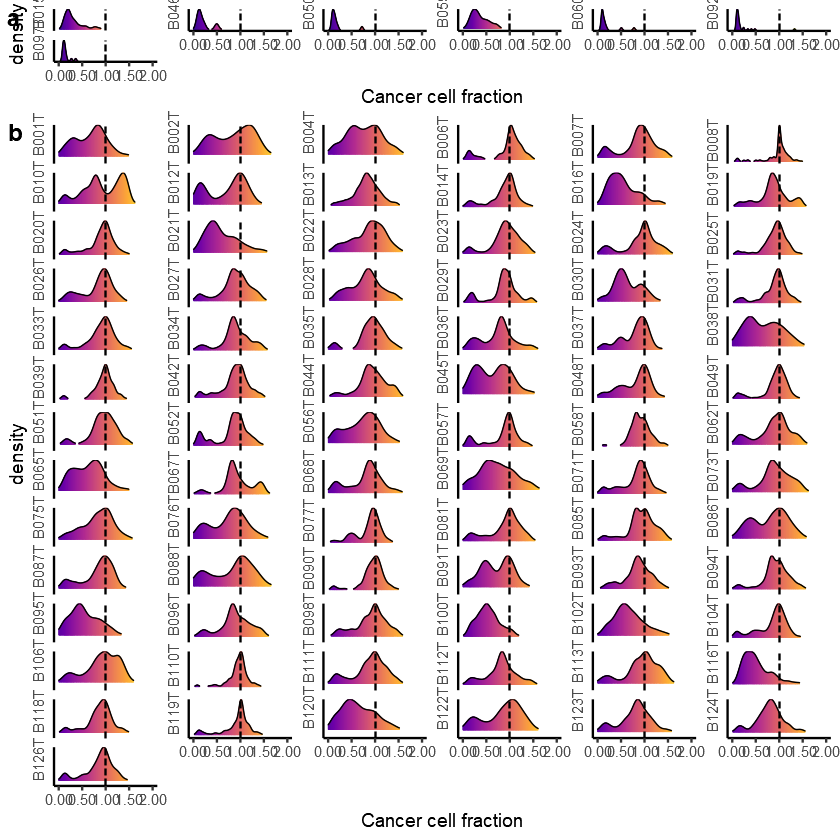

In [107]:
plot_grid(plotlist = list(sfs_tp,sfs_tm),nrow=2,rel_heights = c(1.2,7.5),labels = c('a','b'),label_fontface = 2 )
ggsave("D:/2.crc_trio/draft/toZL/fig4_related/v2/figS14_T.pdf",width = 12,height = 12)
dev.off()
plot_grid(plotlist = list(sfs_pp,sfs_mp),nrow=2,rel_heights = c(1,2.6),labels = c('a','b'),label_fontface = 2 )
ggsave("D:/2.crc_trio/draft/toZL/fig4_related/v2/figS15_P.pdf",width = 12,height = 12)
dev.off()